In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from scipy.integrate import quad

import seaborn as sns
from scipy import stats
from scipy.stats import truncnorm
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

import torch
import torch.nn as nn
import torch.optim as optim
#import torchvision
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
#import torchinfo

import warnings
import os
from copy import deepcopy

import plotting
import dataset_fctns
import modelling_fctns
from ML_fctns import *

from datetime import datetime
from dateutil.relativedelta import relativedelta
#from suntimes import SunTimes  
import sys
sys.path.append("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\optimisation_experiments")
from optimise_GDD_fctns import *

C:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\optimisation_experiments\optimise_GDD_fctns.py:34: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


In [76]:
def run_GDD(x, ds, driver_variable, latlon_proj = True, response_type = 'Trapezoid', 
                             phase_list = ['beginning of flowering'], exclude_unfinished = False,
                             growing_period_length = 300, thresholds = [100], 
                             title_extra='', method='scatter', savename = False, plot=False, col='blue',
                             index_cols = ['lat', 'lon', 'Management', 'vargroup', 'Stations_id', 'year']): 
    #Change index_cols to ['year', 'Stations_id'] if using DE dataset
    len_index_cols = len(index_cols)
    if response_type == 'Trapezoid':
        def response(meantemp):
            #return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])
            return x[0]*modelling_fctns.Trapezoid_Temp_response(meantemp, x[1], x[2], 0.2, 3)#x[3], x[4])
    elif response_type == 'Wang':
        def response(meantemp):
            #return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])
            return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])
    elif response_type == 'Convolved':
        table = vec_expint(x[1], x[2], x[3], np.arange(0, 50, 0.5), 10, 3)#, x[4], x[5])#x[2]
        def response(meantemp):
            return x[0]*table[(np.round(meantemp/5, decimals = 1)*10).astype(int)]*(meantemp > 0)
    elif response_type == 'Convolved_vary_spread':
        table = vec_expint(x[1], x[2], x[3], np.arange(0, 50, 0.5), x[4], x[5])#, x[4], x[5])#x[2]
        def response(meantemp):
            return x[0]*table[(np.round(meantemp/5, decimals = 1)*10).astype(int)]*(meantemp > 0)
    elif response_type == 'multi_phase':
        def response(meantemp):
            #return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])
            return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])
        responses = [lambda meantemp: x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3]),
                     lambda meantemp: x[4]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[5], x[6], x[7])]
    driver_columns = [f'{driver_variable} at day {day}' for day in range(growing_period_length)]
    ds_for_model = ds[driver_columns + index_cols].copy()
    #ds_for_model.loc[:, driver_columns] = ds_for_model.loc[:, driver_columns]#.round(decimals = 10).astype(np.float64)
    if response_type == 'multi_phase':
        t_dev = np.zeros(len(ds_for_model))
        for i, colm in enumerate(driver_columns):
            resp = modelling_fctns.phase_dependent_response2(ds_for_model.loc[:, colm], t_dev, responses, thresholds)
            #resp2 = response(ds_for_model.loc[:, colm])
            #if np.any(resp != resp2):
            #    print(resp, resp2)
            #print(resp)
            t_dev += resp
            ds_for_model.loc[:, colm] = t_dev
    else:
        ds_for_model.loc[:, driver_columns] = response(ds_for_model[driver_columns]).cumsum(axis=1)
    model_dev_time_series = ds_for_model.values.T
    column_names = [np.array([f'modelled time to {phase}' for phase in phase_list]+ index_cols)]
    thresholds_for_phase = thresholds[-1:]
    #print(thresholds_for_phase, model_dev_time_series.shape[1])
    phase_dates_array = np.zeros((len(thresholds_for_phase), model_dev_time_series.shape[1]))#
    for obs_index in range(model_dev_time_series.shape[1]):
        #print(model_dev_time_series[:-2, obs_index])
        #print(model_dev_time_series[:-len_index_cols, obs_index])#.astype(np.float64))
        phase_dates_array[:, obs_index] = np.digitize(thresholds_for_phase, model_dev_time_series[:-len_index_cols, obs_index].astype(np.float64))    
    #print(phase_dates_array)
    phase_dates_array = np.concatenate([phase_dates_array, *[[model_dev_time_series[-(k + 1)]] for k in reversed(range(len_index_cols))]], axis=0)
    #print(column_names)
    phase_dates_array = pd.DataFrame(phase_dates_array.T, columns = column_names[0])
    #print(ds.columns.to_list(), phase_dates_array.columns.to_list())
    comparison_array = ds.T.drop_duplicates().T.merge(phase_dates_array, how='left', on=index_cols).dropna(how='all')
    if plot:
        plot_from_comparison_array(comparison_array, title_extra=title_extra, method=method, savename=savename, 
                                  phase_list=phase_list, exclude_unfinished=exclude_unfinished, growing_period_length=growing_period_length,
                                  col=col)
    return comparison_array

In [2]:
def ML_tensor_from_ds(ds):
    ds=ds.rename(columns={'Referenzjahr':'year'})
    #print(len(ds))
    ds = ds.dropna(how='all')
    #print(len(ds))
    ds = ds.loc[ds['observed time to beginning of flowering'] < 140]
    skip = 1
    numsteps = int(163 // skip)
    new_series = []
    ds.loc[:, [f't2max at day {skip*n}' for n in range(numsteps)]] = ds.loc[:, [f't2max at day {skip*n}' for n in range(numsteps)]].values - ds.loc[:, [f't2m at day {skip*n}' for n in range(numsteps)]].values
    ds.loc[:, [f't2min at day {skip*n}' for n in range(numsteps)]] = ds.loc[:, [f't2m at day {skip*n}' for n in range(numsteps)]].values - ds.loc[:, [f't2min at day {skip*n}' for n in range(numsteps)]].values
    for variable_name in ['t2m', 't2max', 't2min', 'photoperiod', 'vpd']:#['t2m', 'photoperiod', 'vpd']: #, 'ssrd', 'tp', 't2max', 't2min'
        data = ds[[f'{variable_name} at day {skip*n}' for n in range(numsteps)]].values
        #if variable_name != 't2m' and variable_name != 'photoperiod':
        #    scaler = StandardScaler()
        #    scaler.fit(data)
        #    data = scaler.transform(data)
        new_variable_series = torch.Tensor(data)
        new_series.append(new_variable_series)

    day_series = torch.Tensor([[(skip*n)/10 for n in range(numsteps)] for count in range(len(ds))])
    year_series = torch.Tensor([ds['year'].values for count in range(numsteps)]).T
    id_series = torch.Tensor([ds['Stations_id'].values for count in range(numsteps)]).T
    X_tensor = torch.swapaxes(torch.stack((*new_series, day_series, year_series, id_series)), 0, 1)
    ds.loc[:, [f'DTF at day {n}' for n in range(193)]] = np.tile(ds['observed time to beginning of flowering'].values, (193, 1)).T - np.tile(np.arange(0, 193), (len(ds),1))
    ds.loc[:, [f'dev stage at day {skip*n}' for n in range(numsteps)]] = (ds.loc[:, [f'DTF at day {skip*n}' for n in range(numsteps)]] < 0).astype(int).values
    #print(ds[[f'dev stage at day {skip*n}' for n in range(numsteps)]])
    y_tensor = torch.Tensor(ds[[f'dev stage at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_SSA['observed time to beginning of flowering'].astype('int64').values)
    #NDVI_labels_SSA = torch.Tensor(ds_inputs_SSA[[f'DTF at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_SSA['observed time to beginning of flowering'].astype('int64').values)
    #NDVI_labels_SSA = torch.Tensor(ds_inputs_SSA[[f'DTF at day {0}' for n in range(numsteps)]].astype('int64').values)
    return X_tensor, y_tensor

In [3]:
def train_test_ds_by_year(x_train, y_train, test_years = [2015, 2016, 2017], year_column = -2, train_proportion = 0.8):
    samples_in_test_years = torch.isin(x_train[:, year_column, 0], torch.Tensor(test_years))
    train_ds = TensorDataset(x_train[~samples_in_test_years, :, :], y_train[~samples_in_test_years, :])
    val_ds = TensorDataset(x_train[samples_in_test_years, :, :], y_train[samples_in_test_years, :])
    return train_ds, val_ds

def train_test_dl_by_year(x_train, y_train, bs = 500, n_channels=1, train_proportion = 0.8, test_years = [2015, 2016, 2017], year_column = -2):
    train_ds, val_ds = train_test_ds_by_year(x_train, y_train, train_proportion = train_proportion, test_years = test_years, year_column = year_column)
    train_dl = DataLoader(train_ds, batch_size=bs)
    val_dl = DataLoader(val_ds, batch_size=bs)
    train_dl = WrappedDataLoader(train_dl, lambda x, y: preprocess(x, y, channels =n_channels))
    val_dl = WrappedDataLoader(val_dl, lambda x, y: preprocess(x, y, channels =n_channels))
    return train_dl, val_dl

In [4]:
def Wang_Engel_Integral(T, T_min, T_opt, T_max):
    alpha = np.log(2)/np.log( (T_max - T_min)/(T_opt - T_min) )
    f_1 = (2*(np.sign(T - T_min)*(T - T_min))**(alpha + 1))*((T_opt - T_min)**alpha) / (alpha + 1)
    f_2 = ((np.sign(T - T_min)*(T - T_min))**((2*alpha) + 1)) / ((2*alpha) + 1)
    f_T = ( f_1 - f_2 ) / ((T_opt - T_min)**(2*alpha))
    f_T = np.nan_to_num(f_T)

    f_1_max = (2*(T_max - T_min)**(alpha + 1))*((T_opt - T_min)**alpha) / (alpha + 1)
    f_2_max = ((T_max - T_min)**((2*alpha) + 1)) / ((2*alpha) + 1)
    f_T_max = ( f_1_max - f_2_max ) / ((T_opt - T_min)**(2*alpha))
    return f_T*(T >= T_min)*(T<= T_max) + f_T_max*(T > T_max)
    
def Convolved_Wang_Engel(T, T_min, T_opt, T_max, gap = 4):
    return (1/(2*gap))*(Wang_Engel_Integral(np.minimum(T + gap, T_max), T_min, T_opt, T_max) - Wang_Engel_Integral(np.maximum(T - gap, T_min), T_min, T_opt, T_max))#
    
def integrand(T, T_min, T_opt, T_max, d, s, gap):
    #return modelling_fctns.Wang_Engel_Temp_response(T, T_min, T_opt, T_max, beta = 1.5)*np.exp(-((T - d)**2)/(2*(s**2)))
    return Convolved_Wang_Engel(T, T_min, T_opt, T_max, gap = gap)*(1/np.sqrt(2*np.pi*(s**2)))*np.exp(-((T - d)**2)/(2*(s**2)))
    
def expint(T_min, T_opt, T_max, d, s, gap):
    return quad(integrand, T_min, T_max, args=(T_min, T_opt, T_max, d, s, gap))[0]
vec_expint = np.vectorize(expint)

In [5]:
def make_error_df(R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, model, region, eval_method):
    error_df = pd.DataFrame({
        'model': [model],
        'region': [region],
        'evaluation method': [eval_method],
        'R2': [np.mean(R2s)],
        'Bias (obs minus modelled)': [np.mean(Biases)],
        'Variance': [np.mean(Variances)],
        'RMSE': [np.mean(RMSEs)],
        'STD': [np.mean(STDs)],
        'Corr': [np.mean(Corrs)],
        'Min': [np.mean(Mins)],
        'LQ': [np.mean(LQs)],
        'Median': [np.mean(Medians)],
        'UQ': [np.mean(UQs)],
        'Max': [np.mean(Maxs)]
    })
    return error_df

In [6]:
def fit_for_kf(epochs, model, loss_func, opt, train_dl, valid_dl, save_name = 'best_model', plot_opt = False, CNN=False, bce=False, verbose = False):
    # Variables to store training history
    train_losses = []
    val_losses = []
    best_loss = 100000
    best_epoch = 0

    for epoch in range(epochs):
        running_loss = 0.0
        running_samples = 0
        model.train()

        for xb, yb in train_dl:
            batch_loss, batch_len = loss_batch(model, loss_func, xb, yb, opt, CNN=CNN, bce=bce)
            running_loss += batch_loss*batch_len
            running_samples += batch_len

        train_loss = running_loss/running_samples
        
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb, CNN=CNN, bce=bce) for xb, yb in valid_dl]
            )
            
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        # Save the best model (based on validation accuracy)
        if train_loss < best_loss:
            best_loss = train_loss
            best_epoch = epoch + 1
            best_model_state = deepcopy(model.state_dict())
            model_loss = val_loss
        if verbose and np.round((epoch/epochs)*100) % 10 == 0:
            print(epoch, train_loss, val_loss)
        #Save the model at the last epoch
        if epoch == epochs - 1:
            model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
            model_path = os.path.join(model_dir, save_name + ".pt")
            torch.save({'epoch': best_epoch, 'model_state_dict': best_model_state}, model_path)
    #print(f'Loss: {best_loss}')
    if plot_opt:
        plot_train_val_loss(epochs, train_losses, val_losses, best_epoch)
    return model_loss

In [7]:
def K_fold_year_crossval(year_folds, X_tensor, y_tensor, 
                         model_class, epochs, bs, model_args, 
                         savename_prefix = 'KFold', 
                         freeze_params = False, loss = 'NLL', 
                         CNN=False, bce=False, lr = 0.01, 
                         MMD=False, n_channels = 4, 
                         DTF = False, obs_method = False, 
                         custom_loss = None,
                         GDD_init = None, verbose = False):
    # Loop through each fold
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss_values = []
    R2s = []
    Biases = []
    Variances = []

    RMSEs = []
    STDs = []
    Corrs = []

    Mins = []
    LQs = []
    Medians = []
    UQs = []
    Maxs = []
    for fold, year_fold in enumerate(year_folds):
        print(f"Fold {fold + 1}")

        # Define the data loaders for the current fold
        train_dl, val_dl = train_test_dl_by_year(X_tensor, y_tensor, test_years = year_fold, year_column = -2, bs = bs, n_channels = 8, train_proportion=0.8)

        # Initialize the model and optimizer
        model = model_class(*model_args).to(device)
        if GDD_init is not None:
            GDD_params = GDD_init[fold]#[0.31621224, 7.37066436, 22.88481424, 39.40562477]
            print(GDD_params)
            model = initialise_as_GDD(model, *GDD_params, n_channels=5)
        #GDD_params = [0.31621224, 7.37066436, 22.88481424, 39.40562477]
        #model = initialise_as_GDD(model, *GDD_params, n_channels=n_channels)
        optimizer = optim.Adam(model.parameters(), lr=lr)

        if loss == 'NLL':
            criterion = nn.NLLLoss()
        elif loss == 'BCE':
            criterion = nn.BCELoss()
        elif loss == 'MSE':
            criterion = custom_loss()
        # Train the model on the current fold
        if freeze_params:
            for param in [model.u0, model.u1, model.u2, model.u3, model.p0]:
                param.requires_grad = False

        model_loss = fit_for_kf(epochs, model, criterion, optimizer, 
                                train_dl, val_dl, save_name = savename_prefix + str(fold + 1), 
                                CNN=CNN, bce=bce, verbose=verbose)
        loss_values.append(model_loss)

        #Now look at stats for model:
        model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
        model_path = os.path.join(model_dir, savename_prefix + str(fold + 1) + ".pt")
        checkpoint = torch.load(model_path, weights_only=True)
        TS_model = model_class(*model_args).to(device)
        TS_model.load_state_dict(checkpoint['model_state_dict'])

        comparison_frame = get_comparison_frame(savename_prefix + str(fold + 1), TS_model, val_dl, bce=bce, CNN=CNN, MMD=MMD, n_channels = n_channels, DTF = DTF, obs_method = obs_method)
        comparison_frame['Error'] = comparison_frame['observed'] - comparison_frame['fitted']

        bias_model = comparison_frame['Error'].mean()
        RMSE = np.sqrt(np.mean((comparison_frame['Error'] - bias_model)**2))
        STD = comparison_frame['fitted'].std() 
        Corr = comparison_frame['observed'].corr(comparison_frame['fitted'])

        RMSEs.append(RMSE)
        STDs.append(STD)
        Corrs.append(Corr)
        
        Mins.append(comparison_frame['Error'].min())
        LQs.append(comparison_frame['Error'].quantile(0.25))
        Medians.append(comparison_frame['Error'].median())
        UQs.append(comparison_frame['Error'].quantile(0.75))
        Maxs.append(comparison_frame['Error'].max())

        rsquared = r2_score(comparison_frame['observed'], comparison_frame['fitted'])
        print(rsquared)
        bias = comparison_frame['observed'].mean() - comparison_frame['fitted'].mean()
        variance_modelled = comparison_frame[f'fitted'].var()
        
        R2s.append(rsquared)
        Biases.append(bias)
        Variances.append(variance_modelled)

    return loss_values, R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs

In [8]:
def K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, model_args, savename_prefix = 'KFold', freeze_params = False, loss = 'NLL', CNN=False, bce=False, lr = 0.01, MMD=False, n_channels = 4, DTF = False, obs_method = False, custom_loss = None):
    ## LSTM_args: input_dim, hidden_dim, num_layers, output_dim
    # Initialize the k-fold cross validation
    kf = KFold(n_splits=k_folds, shuffle=True, random_state = 1)
    # Loop through each fold
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss_values = []
    R2s = []
    Biases = []
    Variances = []

    RMSEs = []
    STDs = []
    Corrs = []

    Mins = []
    LQs = []
    Medians = []
    UQs = []
    Maxs = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(train_ds)):
        print(f"Fold {fold + 1}")

        # Define the data loaders for the current fold
        train_dl = DataLoader(
            dataset=train_ds,
            batch_size=bs,
            sampler=torch.utils.data.SubsetRandomSampler(train_idx),
        )
        val_dl = DataLoader(
            dataset=train_ds,
            batch_size=bs,
            sampler=torch.utils.data.SubsetRandomSampler(test_idx),
        )

        # Initialize the model and optimizer
        model = model_class(*model_args).to(device)
        
        optimizer = optim.Adam(model.parameters(), lr=lr)

        if loss == 'NLL':
            criterion = nn.NLLLoss()
        elif loss == 'BCE':
            criterion = nn.BCELoss()
        elif loss == 'MSE':
            criterion = custom_loss()
        # Train the model on the current fold
        if freeze_params:
            for param in [model.u0, model.u1, model.u2, model.u3, model.p0]:
                param.requires_grad = False

        model_loss = fit_for_kf(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = savename_prefix + str(fold + 1), CNN=CNN, bce=bce)
        loss_values.append(model_loss)

        #Now look at stats for model:
        model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
        model_path = os.path.join(model_dir, savename_prefix + str(fold + 1) + ".pt")
        checkpoint = torch.load(model_path, weights_only=True)
        TS_model = model_class(*model_args).to(device)
        TS_model.load_state_dict(checkpoint['model_state_dict'])

        comparison_frame, logs = get_comparison_frame(savename_prefix + str(fold + 1), TS_model, val_dl, bce=bce, CNN=CNN, MMD=MMD, n_channels = n_channels, DTF = DTF, obs_method = obs_method)
        comparison_frame['Error'] = comparison_frame['observed'] - comparison_frame['fitted']

        bias_model = comparison_frame['Error'].mean()
        RMSE = np.sqrt(np.mean((comparison_frame['Error'] - bias_model)**2))
        STD = comparison_frame['fitted'].std() 
        Corr = comparison_frame['observed'].corr(comparison_frame['fitted'])

        RMSEs.append(RMSE)
        STDs.append(STD)
        Corrs.append(Corr)
        
        Mins.append(comparison_frame['Error'].min())
        LQs.append(comparison_frame['Error'].quantile(0.25))
        Medians.append(comparison_frame['Error'].median())
        UQs.append(comparison_frame['Error'].quantile(0.75))
        Maxs.append(comparison_frame['Error'].max())

        rsquared = r2_score(comparison_frame['observed'], comparison_frame['fitted'])
        bias = comparison_frame['observed'].mean() - comparison_frame['fitted'].mean()
        variance_modelled = comparison_frame[f'fitted'].var()
        
        R2s.append(rsquared)
        Biases.append(bias)
        Variances.append(variance_modelled)

    return loss_values, R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs

In [112]:
def K_fold_transfer(k_folds, ds, model_class, 
                    savename, epochs, bs, model_args, 
                    lr = 0.01, savename_prefix = 'KFold',
                    loss = 'NLL', 
                    CNN=False, bce=False, custom_loss = None, 
                    MMD = False, DTF = False, obs_method = False,
                    all_wang = False):
    ## LSTM_args: input_dim, hidden_dim, num_layers, output_dim
    # Initialize the k-fold cross validation
    # Loop through each fold
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss_values = []
    R2s = []
    Biases = []
    Variances = []
    obsvars = []

    RMSEs = []
    SSEs = []
    STDs = []
    Corrs = []

    Mins = []
    LQs = []
    Medians = []
    UQs = []
    Maxs = []

    lengths = []
    kf = KFold(n_splits=k_folds, shuffle=True, random_state = 1)
    statyear = ds[['Stations_id', 'Referenzjahr']].drop_duplicates()
    for fold, (train_idx, test_idx) in enumerate(kf.split(statyear)):
        train_statyear = statyear.iloc[train_idx]
        test_statyear = statyear.iloc[test_idx]
        train = ds.merge(train_statyear, on=['Stations_id', 'Referenzjahr'], how = 'inner') #.loc[ds[['Stations_id', 'year']].isin(train_statyear)]
        test = ds.merge(test_statyear, on=['Stations_id', 'Referenzjahr'], how = 'inner')
        lengths.append(len(test))
        #print(f"Fold {fold + 1}")
        X_tensor_train, y_tensor_train = ML_tensor_from_ds(train)
        X_tensor_test, y_tensor_test = ML_tensor_from_ds(test)
        #print(len(ds), X_tensor_test.shape, X_tensor_train.shape)
        train_ds, ___ = train_test_ds_from_tensors(X_tensor_train, y_tensor_train, train_proportion=1)
        val_ds, ___ = train_test_ds_from_tensors(X_tensor_test, y_tensor_test, train_proportion=1)
        # Define the data loaders for the current fold
        train_dl = DataLoader(
            dataset=train_ds,
            batch_size=bs,
        )
        val_dl = DataLoader(
            dataset=val_ds,
            batch_size=bs,
        )
        model = model_class(*model_args).to(device)
        model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
        model_path = os.path.join(model_dir, savename + ".pt")
        checkpoint = torch.load(model_path, weights_only=True)
        model.load_state_dict(checkpoint['model_state_dict'])
        for param in model.parameters():
            param.requires_grad = False
        if all_wang:
            for param in [model.u0, model.u1, model.u2, model.u3]:
                param.requires_grad = True
        else:
            for param in [model.u4]:
                param.requires_grad = True
        
        optimizer = optim.Adam(model.parameters(), lr=lr)
        if loss == 'NLL':
            criterion = nn.NLLLoss()
        elif loss == 'BCE':
            criterion = nn.BCELoss()
        elif loss == 'MSE':
            criterion = custom_loss
        # Train the model on the current fold

        #for param in [model.u0, model.u1, model.u2, model.u3, model.p0]:
        #    print(param.requires_grad, param.shape)
        model_loss = fit_for_kf(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = savename_prefix + str(fold + 1), CNN=CNN, bce=bce, plot_opt=False, verbose=False)
        loss_values.append(model_loss)

        #Now look at stats for model:
        model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
        model_path = os.path.join(model_dir, savename_prefix + str(fold + 1) + ".pt")
        checkpoint = torch.load(model_path, weights_only=True)
        TS_model = model_class(*model_args).to(device)
        TS_model.load_state_dict(checkpoint['model_state_dict'])
        # Now convert to days and get R^2 to compare to other models
        list_logs = []
        list_GDD_logs = []
        list_observed = []
        for xb, yb in val_dl:
            with torch.no_grad():
                if CNN:
                    if MMD:
                        list_logs.append(TS_model(xb)[0])
                        list_GDD_logs.append(TS_model(xb, no_nn=True)[0])
                    else:
                        list_logs.append(TS_model(xb))
                        list_GDD_logs.append(TS_model(xb, no_nn=True))
                else:
                    list_logs.append(TS_model(xb.transpose(1, 2)))
                    list_GDD_logs.append(TS_model(xb.transpose(1, 2), no_nn=True))
                #print(TS_model(xb.transpose(1, 2)))
            list_observed.append(yb)
        logs = torch.squeeze(torch.cat(list_logs))
        GDD_logs = torch.squeeze(torch.cat(list_GDD_logs))
        observed = torch.cat(list_observed)
        #print(logs.shape, torch.cat(list_logs, dim=0).shape)
        if not(DTF):
            if bce:
                fitted = torch.round(logs)
                fitted_GDD = torch.round(GDD_logs)
            else:
                fitted = torch.argmax(logs, dim=2)
                fitted_GDD = torch.argmax(GDD_logs, dim=2)
        if DTF:
            logs = torch.round(logs)
            observed_days = mindex_at_0(observed)
            observed_days = observed[:, 0]
            observed_days = 90 + 100 - observed[:, 90]
            if obs_method:
                fitted_days = observed_days + logs[range(0, logs.shape[0]), observed_days.int()]
            else:
                fitted_days = mindex_at_0(logs)
                fitted_days = 90 + 100 - logs[:, 90]
                #fitted_days = logs[:, 90]
            #print(torch.sum(fitted_days < 30), ' fits too small')
        else:
            L = fitted.shape[1]
            fitted_days = L - fitted.sum(dim=1)
            observed_days = L - observed.sum(dim=1)
            GDD_days = L - fitted_GDD.sum(dim=1)
        
        comparison_frame = pd.DataFrame({'fitted': fitted_days.numpy().squeeze(), 'observed': observed_days.numpy().squeeze(), 'GDD fitted': GDD_days.numpy().squeeze()})
        comparison_frame['Error'] = comparison_frame['observed'] - comparison_frame['fitted']
        T_min = (9 + 10*(torch.tanh(TS_model.u1)) - 4).detach().cpu().numpy() #normally multiplier = 2
        T_opt = (28 + 7*(torch.tanh(TS_model.u2)) - 4).detach().cpu().numpy() #normally multiplier = 3
        T_max = (39 + 3.5*torch.tanh(TS_model.u3)).detach().cpu().numpy()#normally no multiplier
        scale = TS_model.u4.detach().cpu().numpy()
        threshold = TS_model.u0.detach().cpu().numpy()[0]
        x=[scale[0], T_min[0], T_opt[0], T_max[0]]
        #print(x, threshold)
        #print(test.columns.to_list())
        #cf2 = run_GDD(x, test.rename(columns={'Referenzjahr': 'year'}), 't2m', response_type='Wang', thresholds =[threshold], growing_period_length = 120)
        #print(cf2['modelled time to beginning of flowering'])
        #comparison_frame['GDD_fitted'] = cf2['modelled time to beginning of flowering'].values
        bias_model = 0#comparison_frame['Error'].mean()
        RMSE = np.sqrt(np.mean((comparison_frame['Error'] - bias_model)**2))
        SSE = np.sum((comparison_frame['Error'] - bias_model)**2)
        STD = comparison_frame['fitted'].std() 
        Corr = comparison_frame['observed'].corr(comparison_frame['fitted'])

        RMSEs.append(RMSE)
        SSEs.append(SSE)
        STDs.append(STD)
        Corrs.append(Corr)
        
        Mins.append(comparison_frame['Error'].min())
        LQs.append(comparison_frame['Error'].quantile(0.25))
        Medians.append(comparison_frame['Error'].median())
        UQs.append(comparison_frame['Error'].quantile(0.75))
        Maxs.append(comparison_frame['Error'].max())

        rsquared = r2_score(comparison_frame['observed'], comparison_frame['fitted'])
        bias = comparison_frame['observed'].mean() - comparison_frame['fitted'].mean()
        variance_modelled = comparison_frame[f'fitted'].var()
        variance_observed = comparison_frame['observed'].var()
        
        R2s.append(rsquared)
        Biases.append(bias)
        Variances.append(variance_modelled)
        obsvars.append(variance_observed)
        if fold == 0:
            comparison_frame_full = comparison_frame
        else:
            comparison_frame_full = pd.concat((comparison_frame, comparison_frame_full))

    return comparison_frame_full, loss_values, R2s, Biases, Variances, RMSEs, SSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, lengths, obsvars

In [78]:
cf2 = run_GDD([0.3, 5, 23, 31], ds_inputs_SSA.rename(columns={'Referenzjahr': 'year'}), 't2m', response_type='Wang', thresholds =[20], growing_period_length = 180)

In [69]:
ds_inputs_SSA.rename(columns={'Referenzjahr': 'year'}).T.drop_duplicates().T.columns.to_list()

['Unnamed: 0',
 'WC SOS date',
 'Stations_id',
 'lat',
 'lon',
 'Management',
 'vargroup',
 'year',
 't2m at day 0',
 't2m at day 1',
 't2m at day 2',
 't2m at day 3',
 't2m at day 4',
 't2m at day 5',
 't2m at day 6',
 't2m at day 7',
 't2m at day 8',
 't2m at day 9',
 't2m at day 10',
 't2m at day 11',
 't2m at day 12',
 't2m at day 13',
 't2m at day 14',
 't2m at day 15',
 't2m at day 16',
 't2m at day 17',
 't2m at day 18',
 't2m at day 19',
 't2m at day 20',
 't2m at day 21',
 't2m at day 22',
 't2m at day 23',
 't2m at day 24',
 't2m at day 25',
 't2m at day 26',
 't2m at day 27',
 't2m at day 28',
 't2m at day 29',
 't2m at day 30',
 't2m at day 31',
 't2m at day 32',
 't2m at day 33',
 't2m at day 34',
 't2m at day 35',
 't2m at day 36',
 't2m at day 37',
 't2m at day 38',
 't2m at day 39',
 't2m at day 40',
 't2m at day 41',
 't2m at day 42',
 't2m at day 43',
 't2m at day 44',
 't2m at day 45',
 't2m at day 46',
 't2m at day 47',
 't2m at day 48',
 't2m at day 49',
 't2m at d

In [61]:
ds_inputs_SSA.rename(columns={'Referenzjahr': 'year'}).columns.to_list()

['Unnamed: 0',
 'WC SOS date',
 'Stations_id',
 'lat',
 'lon',
 'Management',
 'vargroup',
 'year',
 't2m at day 0',
 't2m at day 1',
 't2m at day 2',
 't2m at day 3',
 't2m at day 4',
 't2m at day 5',
 't2m at day 6',
 't2m at day 7',
 't2m at day 8',
 't2m at day 9',
 't2m at day 10',
 't2m at day 11',
 't2m at day 12',
 't2m at day 13',
 't2m at day 14',
 't2m at day 15',
 't2m at day 16',
 't2m at day 17',
 't2m at day 18',
 't2m at day 19',
 't2m at day 20',
 't2m at day 21',
 't2m at day 22',
 't2m at day 23',
 't2m at day 24',
 't2m at day 25',
 't2m at day 26',
 't2m at day 27',
 't2m at day 28',
 't2m at day 29',
 't2m at day 30',
 't2m at day 31',
 't2m at day 32',
 't2m at day 33',
 't2m at day 34',
 't2m at day 35',
 't2m at day 36',
 't2m at day 37',
 't2m at day 38',
 't2m at day 39',
 't2m at day 40',
 't2m at day 41',
 't2m at day 42',
 't2m at day 43',
 't2m at day 44',
 't2m at day 45',
 't2m at day 46',
 't2m at day 47',
 't2m at day 48',
 't2m at day 49',
 't2m at d

In [10]:
def K_fold_transfer_regions(ds_dict, transfer_method = 'just rate'):
    if transfer_method == 'just rate':
        all_wang = False
    else:
        all_wang = True
    bs = 30000
    n_channels = 5
    input_dim = n_channels # Example: 100-dimensional word embeddings
    hidden_dim = 16#day2 -> 8#day -> 16 #day3 ->4
    num_layers = 4#day3 -> 8
    output_dim = 1  # Example: 5 classes
    KG = False
    KG2 = True
    CNN = False
    bce=True

    model_args = (input_dim, hidden_dim, num_layers, output_dim, KG, KG2)
    save_name = 'NN_response_DE_no_day5'
    lr = 0.01
    epochs = 500
    # initialise lists for storing
    SSE_all_reg = []
    length_all_reg = []
    obsvars_all_reg = []
    regs = []
    comparison_frames = []
    for region in ds_dict.keys():
        #get data for specific region
        ds = ds_dict[region]
        if len(ds) < 20:
            continue
        regs.append(region)
        #convert to pytorch format
        #X_tensor, y_tensor = ML_tensor_from_ds(ds)
        #train_ds, val_ds = train_test_ds_from_tensors(X_tensor, y_tensor, train_proportion=1)
        #run K-fold cross validation
        criterion = problist_square_loss()
        comparison_frame, loss_values, R2s, Biases, Variances, RMSEs, SSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, lengths, obsvars = K_fold_transfer(5, ds, nn_temp_response, 
                                                                                                                save_name, epochs, bs, model_args,lr = lr, 
                                                                                                                loss = 'MSE', CNN=CNN, bce=bce, 
                                                                                                                custom_loss=criterion, DTF = False, all_wang=all_wang)
        comparison_frames.append(comparison_frame)
        print(region, R2s)
        #Store sum of squared errors, variance of obs and length of folds for evaluation
        SSE_all_reg.append(SSEs)
        length_all_reg.append(lengths)
        obsvars_all_reg.append(obsvars)
    results_dict = {'SSEs': SSE_all_reg,
                    'observed variances': obsvars_all_reg,
                    'fold lengths': length_all_reg,
                    'regions': regs,
                    'comparison_frames': comparison_frames}
    return results_dict

In [11]:
def get_comparison_frame(savename, TS_model, dl, bce=False, CNN=False, MMD=False, n_channels = 4, DTF = False, obs_method = False):
    model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
    model_path = os.path.join(model_dir, savename + ".pt")
    checkpoint = torch.load(model_path, weights_only=True)
    TS_model.load_state_dict(checkpoint['model_state_dict'])
    list_logs = []
    list_observed = []
    list_stations = []
    list_years = []
    for xb, yb in dl:
        with torch.no_grad():
            if CNN:
                if MMD:
                    list_logs.append(TS_model(xb)[0])
                else:
                    list_logs.append(TS_model(xb))
            else:
                list_logs.append(TS_model(xb.transpose(1, 2)))
            list_years.append(xb[:, n_channels, 0])
            list_stations.append(xb[:, n_channels + 1, 0])
            #print(TS_model(xb.transpose(1, 2)))
        list_observed.append(yb)
    logs = torch.squeeze(torch.cat(list_logs))
    stations = torch.squeeze(torch.cat(list_stations))
    years = torch.squeeze(torch.cat(list_years))
    observed = torch.cat(list_observed)
    #print(logs.shape, torch.cat(list_logs, dim=0).shape)
    if not(DTF):
        if bce:
            fitted = torch.round(logs)
        else:
            fitted = torch.argmax(logs, dim=2)
    if DTF:
        logs = torch.round(logs)
        observed_days = mindex_at_0(observed)
        observed_days = observed[:, 0]
        observed_days = 90 + 100 - observed[:, 90]
        if obs_method:
            fitted_days = observed_days + logs[range(0, logs.shape[0]), observed_days.int()]
        else:
            fitted_days = mindex_at_0(logs)
            fitted_days = 90 + 100 - logs[:, 90]
            #fitted_days = logs[:, 90]
        print(torch.sum(fitted_days < 30), ' fits too small')
    else:
        L = fitted.shape[1]
        fitted_days = L - fitted.sum(dim=1)
        observed_days = L - observed.sum(dim=1)
    #print(stations.numpy().squeeze())
    comparison_frame = pd.DataFrame({'Stations_id': stations.numpy().squeeze(), 'year': years.numpy().squeeze(), 'fitted': fitted_days.numpy().squeeze(), 'observed': observed_days.numpy().squeeze()})
    return comparison_frame
    

In [12]:
#def get_comparison_frame(savename, TS_model, dl, bce=False, CNN=False):
#    model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
#    model_path = os.path.join(model_dir, savename + ".pt")
#    checkpoint = torch.load(model_path, weights_only=True)
#    TS_model.load_state_dict(checkpoint['model_state_dict'])
#    list_logs = []
#    list_observed = []
#    list_stations = []
#    list_years = []
#    for xb, yb in dl:
#        with torch.no_grad():
#            if CNN:
#                list_logs.append(TS_model(xb))
#            else:
#                list_logs.append(TS_model(xb.transpose(1, 2)))
#            list_years.append(xb[:, 4, 0])
#            list_stations.append(xb[:, 5, 0])
#            #print(TS_model(xb.transpose(1, 2)))
#        list_observed.append(yb)
#    logs = torch.squeeze(torch.cat(list_logs))
#    stations = torch.squeeze(torch.cat(list_stations))
#    years = torch.squeeze(torch.cat(list_years))
#    if bce:
#        fitted = torch.round(logs)
#    else:
#        fitted = torch.argmax(logs, dim=2)
#    L = fitted.shape[1]
#    fitted_days = L - fitted.sum(dim=1)
#    observed = torch.cat(list_observed)
#    observed_days = L - observed.sum(dim=1)
#    #print(stations.numpy().squeeze())
#    comparison_frame = pd.DataFrame({'Stations_id': stations.numpy().squeeze(), 'year': years.numpy().squeeze(), 'fitted': fitted_days.numpy().squeeze(), 'observed': observed_days.numpy().squeeze()})
#    return comparison_frame
    

In [16]:
def get_comparison_frame(savename, TS_model, dl, bce=False, CNN=False, MMD=False, n_channels = 4, DTF = False, obs_method = False, prediction_day = 0):
    model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
    model_path = os.path.join(model_dir, savename + ".pt")
    checkpoint = torch.load(model_path, weights_only=True)
    TS_model.load_state_dict(checkpoint['model_state_dict'])
    list_logs = []
    list_observed = []
    list_stations = []
    list_years = []
    for xb, yb in dl:
        with torch.no_grad():
            if CNN:
                if MMD:
                    list_logs.append(TS_model(xb)[0])
                else:
                    list_logs.append(TS_model(xb))
                    print(TS_model(xb)[0, :])
            else:
                list_logs.append(TS_model(xb.transpose(1, 2)))
            list_years.append(xb[:, n_channels, 0])
            list_stations.append(xb[:, n_channels + 1, 0])
            #print(TS_model(xb.transpose(1, 2)))
        list_observed.append(yb)
    logs = torch.squeeze(torch.cat(list_logs))
    #print(logs[0, :])
    stations = torch.squeeze(torch.cat(list_stations))
    years = torch.squeeze(torch.cat(list_years))
    observed = torch.cat(list_observed)
    #print(logs.shape, torch.cat(list_logs, dim=0).shape)
    if not(DTF):
        if bce:
            fitted = torch.round(logs)
        else:
            fitted = torch.argmax(logs, dim=2)
    if DTF:
        logs = torch.round(logs)
        observed_days = mindex_at_0(observed)
        #observed_days = observed[:, 0]
        #observed_days = 90 + 100 - observed[:, 90]
        #observed_days = prediction_day + observed[:, prediction_day]
        if obs_method:
            fitted_days = observed_days + logs[range(0, logs.shape[0]), observed_days.int()]
        else:
            fitted_days = mindex_at_0(logs)
            #fitted_days = 90 + 100 - logs[:, 90]
            #fitted_days = logs[:, 90]
            #fitted_days = prediction_day + logs[:, prediction_day]
        print(torch.sum(fitted_days < 30), ' fits too small')
    else:
        L = fitted.shape[1]
        fitted_days = L - fitted.sum(dim=1)
        observed_days = L - observed.sum(dim=1)
    #print(stations.numpy().squeeze())
    comparison_frame = pd.DataFrame({'Stations_id': stations.numpy().squeeze(), 'year': years.numpy().squeeze(), 'fitted': fitted_days.numpy().squeeze(), 'observed': observed_days.numpy().squeeze()})
    return comparison_frame, logs

In [13]:
def subset_ds_from_tensors(x_train, y_train, train_proportion = 0.2):
    full_ds = TensorDataset(x_train, y_train)
    train_size = int(train_proportion * len(full_ds))
    val_size = int(len(full_ds) - (1/train_proportion - 1)*train_size)
    split_ds = random_split(full_ds, [train_size, train_size, train_size, train_size, val_size])
    return split_ds

def subset_dl_from_tensors(x_train, y_train, bs = 500, n_channels=1, train_proportion = 0.2):
    split_dl = []
    split_ds = subset_ds_from_tensors(x_train, y_train, train_proportion = train_proportion)
    for ds in split_ds:
        dl = DataLoader(ds, batch_size=bs)
        dl = WrappedDataLoader(dl, lambda x, y: preprocess(x, y, channels =n_channels))
        split_dl.append(dl)
    return split_dl

In [14]:
skip = 1
numsteps = int(163 // skip)
#ds_inputs_DE1 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_2001_2024_full.csv')
#ds_inputs_DE1[[f't2max at day {skip*n}' for n in range(numsteps)]] += -273.15
#ds_inputs_DE1[[f't2min at day {skip*n}' for n in range(numsteps)]] += -273.15
#ds_inputs_DE2 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_90s.csv')

#ds_inputs_DE = pd.concat([ds_inputs_DE1, ds_inputs_DE2], axis = 0)
ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_full.csv')
#ds_inputs_DE.loc[:, [f'temperature at day {n}' for n in range(200)]] = modelling_fctns.Wang_Engel_Temp_response(ds_inputs_DE.loc[:, [f'temperature at day {n}' for n in range(200)]], 7, 28, 42)
ds_inputs_DE=ds_inputs_DE.rename(columns={'Referenzjahr':'year'})
print(len(ds_inputs_DE))
ds_inputs_DE = ds_inputs_DE.dropna(how='all')
print(len(ds_inputs_DE))
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['observed time to beginning of flowering'] < 140]
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['observed time to beginning of flowering'] > 40]
new_series = []
ds_inputs_DE.loc[:, [f't2max at day {skip*n}' for n in range(numsteps)]] = ds_inputs_DE.loc[:, [f't2max at day {skip*n}' for n in range(numsteps)]].values - ds_inputs_DE.loc[:, [f't2m at day {skip*n}' for n in range(numsteps)]].values
ds_inputs_DE.loc[:, [f't2min at day {skip*n}' for n in range(numsteps)]] = ds_inputs_DE.loc[:, [f't2m at day {skip*n}' for n in range(numsteps)]].values - ds_inputs_DE.loc[:, [f't2min at day {skip*n}' for n in range(numsteps)]].values
for variable_name in ['t2m', 't2max', 't2min', 'photoperiod', 'vpd']: #, 'ssrd', 'tp'
    data = ds_inputs_DE[[f'{variable_name} at day {skip*n}' for n in range(numsteps)]].values
    #if variable_name != 't2m' and variable_name != 'photoperiod':
    #    scaler = StandardScaler()
    #    scaler.fit(data)
    #    data = scaler.transform(data)
    new_variable_series = torch.Tensor(data)
    new_series.append(new_variable_series)

day_series_DE = torch.Tensor([[(skip*n)/10 for n in range(numsteps)] for count in range(len(ds_inputs_DE))])
year_series_DE = torch.Tensor([ds_inputs_DE['year'].values for count in range(numsteps)]).T
id_series_DE = torch.Tensor([ds_inputs_DE['Stations_id'].values for count in range(numsteps)]).T
temp_NDVI_series_DE = torch.swapaxes(torch.stack((*new_series, day_series_DE, year_series_DE, id_series_DE)), 0, 1)
ds_inputs_DE.loc[:, [f'DTF at day {n}' for n in range(193)]] = np.tile(ds_inputs_DE['observed time to beginning of flowering'].values, (193, 1)).T - np.tile(np.arange(0, 193), (len(ds_inputs_DE),1))
NDVI_labels_DE = torch.Tensor(ds_inputs_DE[[f'dev stage at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype('int64').values)

#NDVI_labels_DE = torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype(int).values).unsqueeze(1)
#NDVI_labels_DE = 100 - torch.Tensor(ds_inputs_DE[[f'DTF at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype('int64').values)
#NDVI_labels_DE = torch.Tensor(ds_inputs_DE[[f'DTF at day {skip*n}' for n in range(numsteps)]].astype('int64').values)

27153
27153


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_10472\356867199.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_34s6o8i12c\croot\libtorch_1751464457133\work\torch\csrc\utils\tensor_new.cpp:257.)
  year_series_DE = torch.Tensor([ds_inputs_DE['year'].values for count in range(numsteps)]).T


In [15]:
ds_inputs_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\SSA_ML_ERA5_1999_2008_with_varieties_fixed_vpd.csv')
#ds_inputs_SSA.loc[:, [f'temperature at day {n}' for n in range(200)]] = modelling_fctns.Wang_Engel_Temp_response(ds_inputs_SSA.loc[:, [f'temperature at day {n}' for n in range(200)]], 7, 28, 42)
ds_inputs_SSA=ds_inputs_SSA.rename(columns={'Referenzjahr':'year'})
print(len(ds_inputs_SSA))
ds_inputs_SSA = ds_inputs_SSA.dropna(how='all')
print(len(ds_inputs_SSA))
ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['observed time to beginning of flowering'] < 140]
skip = 1
numsteps = int(163 // skip)
new_series = []
for variable_name in ['t2m', 't2max', 't2min', 'photoperiod', 'vpd']: #, 'ssrd', 'tp', 't2max', 't2min'
    data = ds_inputs_SSA[[f'{variable_name} at day {skip*n}' for n in range(numsteps)]].values
    if variable_name != 't2m' and variable_name != 'photoperiod':
        scaler = StandardScaler()
        scaler.fit(data)
        data = scaler.transform(data)
    new_variable_series = torch.Tensor(data)
    new_series.append(new_variable_series)

day_series_SSA = torch.Tensor([[(skip*n)/10 for n in range(numsteps)] for count in range(len(ds_inputs_SSA))])
year_series_SSA = torch.Tensor([ds_inputs_SSA['year'] for count in range(numsteps)]).T
id_series_SSA = torch.Tensor([ds_inputs_SSA['Stations_id'] for count in range(numsteps)]).T
temp_NDVI_series_SSA = torch.swapaxes(torch.stack((*new_series, day_series_SSA, year_series_SSA, id_series_SSA)), 0, 1)
ds_inputs_SSA.loc[:, [f'DTF at day {n}' for n in range(193)]] = np.tile(ds_inputs_SSA['observed time to beginning of flowering'].values, (193, 1)).T - np.tile(np.arange(0, 193), (len(ds_inputs_SSA),1))
ds_inputs_SSA.loc[:, [f'dev stage at day {skip*n}' for n in range(numsteps)]] = (ds_inputs_SSA.loc[:, [f'DTF at day {skip*n}' for n in range(numsteps)]] < 0).astype(int).values
NDVI_labels_SSA = torch.Tensor(ds_inputs_SSA[[f'dev stage at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_SSA['observed time to beginning of flowering'].astype('int64').values)
#NDVI_labels_SSA = 100 - torch.Tensor(ds_inputs_SSA[[f'DTF at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_SSA['observed time to beginning of flowering'].astype('int64').values)
#NDVI_labels_SSA = torch.Tensor(ds_inputs_SSA[[f'DTF at day {0}' for n in range(numsteps)]].astype('int64').values)

703
703


In [16]:
def loss_batch(model, loss_func, xb, yb, opt=None, CNN=False, bce=False):
    if CNN:
        outputs = model(xb)
        loss = loss_func(torch.squeeze(outputs.transpose(1, 2)), torch.squeeze(yb.float()))
    elif bce:
        outputs = model(xb.transpose(1, 2))
        loss = loss_func(torch.squeeze(outputs.float()), torch.squeeze(yb.float()))#.transpose(1, 2)
    else:
        outputs = model(xb.transpose(1, 2))
        loss = loss_func(outputs.transpose(1, 2), yb.long())

    if opt is not None:
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 100)
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [17]:
def fit_on_subsets(x_train, y_train, model_class, epochs, bs, model_args, savename_prefix = 'subset_coeffs', freeze_params = False, loss = 'NLL', CNN=False, bce=False):
    split_dl = subset_dl_from_tensors(x_train, y_train)
    coeffs_list = []
    loss_values = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for fold, train_dl in enumerate(split_dl):
        
        val_dl = split_dl[fold - 1]
        print(f"Fold {fold + 1}")
        # Initialize the model and optimizer
        model = model_class(*model_args).to(device)
        
        optimizer = optim.Adam(model.parameters(), lr=0.01)

        if loss == 'NLL':
            criterion = nn.NLLLoss()
        elif loss == 'BCE':
            criterion = nn.BCELoss()
        # Train the model on the current fold
        if freeze_params:
            for param in [model.u0, model.u1, model.u2, model.u3, model.p0]:
                param.requires_grad = False
        for xb, yb in train_dl:
            batch_loss, batch_len = loss_batch(model, criterion, xb, yb, optimizer, CNN=CNN, bce=bce)
        model_loss = fit_for_kf(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = savename_prefix + str(fold + 1), CNN=CNN, bce=bce)
        loss_values.append(model_loss)

        #Now look at stats for model:
        model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
        model_path = os.path.join(model_dir, savename_prefix + str(fold + 1) + ".pt")
        checkpoint = torch.load(model_path, weights_only=True)
        TS_model = model_class(*model_args).to(device)
        TS_model.load_state_dict(checkpoint['model_state_dict'])

        coeffs = []
        for name, param in TS_model.named_parameters():
            if param.requires_grad:
                print(name, param.data)
                coeffs.append(param.data)
        coeffs = coeffs[:-4]

        def B_0(u):
            return ((1 - u**2)**2)*(u >= -1)*(u <= 1) #np.maximum((1/6)*(-(x**3) + 3*(x**2) - 3*x + 1), 0)

        def response(meantemp):
            resp = 0
            for i, coeff in enumerate(coeffs):
                resp += torch.abs(coeff)*B_0(0.25*(meantemp - i*2))
            return resp
            
        fig, ax = plt.subplots()
        ax.plot(np.arange(0, 45, 0.5), response(np.arange(0, 45, 0.5)))
        maxval = np.arange(0, 45, 0.5)[response(np.arange(0, 45, 0.5)).argmax()]
        print(maxval)
        ax.axvline(maxval)
        ax.axhline(0)
        coeffs_list.append(coeffs)
    return coeffs_list

In [18]:
class problist_square_loss(nn.Module):
    def __init__(self):
        super(problist_square_loss, self).__init__()
    def forward(self, logits, targets):
        discrepancy = (targets - logits)**2
        #print(discrepancy[0, :])
        #print((discrepancy.sum(dim=1)**2)[0])
        return (discrepancy.sum(dim=1)**2).mean()

In [113]:
class nn_temp_response(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, KG=False, KG2 = False):
        super(nn_temp_response, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim
        self.KG = KG
        self.KG2 = KG2

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=False) # batch_first handles input shape (batch, seq, features)
        if self.KG2:
            self.input_layer = nn.Linear(input_dim, hidden_dim)
        else:
            self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.layer1 = nn.Linear(hidden_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.layer4= nn.Linear(hidden_dim, hidden_dim)
        self.layer5 = nn.Linear(hidden_dim, hidden_dim)
        self.layer6= nn.Linear(hidden_dim, hidden_dim)
        self.layer7 = nn.Linear(hidden_dim, hidden_dim)
        self.layer8 = nn.Linear(hidden_dim, hidden_dim)
        self.layer9 = nn.Linear(hidden_dim, hidden_dim)
        self.layer10= nn.Linear(hidden_dim, hidden_dim)
        self.layer11 = nn.Linear(hidden_dim, hidden_dim)
        self.layer12 = nn.Linear(hidden_dim, hidden_dim)
        self.layer13= nn.Linear(hidden_dim, hidden_dim)
        self.layer14 = nn.Linear(hidden_dim, hidden_dim)
        self.layer15 = nn.Linear(hidden_dim, hidden_dim)
        self.layer16 = nn.Linear(hidden_dim, hidden_dim)
        self.layer17 = nn.Linear(hidden_dim, hidden_dim)
        self.layer18 = nn.Linear(hidden_dim, hidden_dim)
        self.layers_list = [self.input_layer, self.layer1, self.layer2, self.layer3,
                            self.layer4, self.layer5, self.layer6,
                            self.layer7, self.layer8, self.layer9,
                            self.layer10, self.layer11, self.layer12,
                            self.layer13, self.layer14, self.layer15,
                            self.layer16, self.layer17, self.layer18]
        self.fc = nn.Linear(hidden_dim, output_dim)  # Fully connected layer for classification
        self.input_dim = input_dim
        self.sig = nn.Sigmoid()

        #self.activation = nn.LeakyReLU(negative_slope=0.01)
        self.activation = nn.Tanh()

        self.u0 = torch.nn.Parameter(torch.Tensor([20])) #Now TTR
        self.u1 = torch.nn.Parameter(torch.Tensor([0])) #not used
        self.u2 = torch.nn.Parameter(torch.Tensor([0])) # not used
        self.u3 = torch.nn.Parameter(torch.Tensor([0])) #not used
        self.u4 = torch.nn.Parameter(torch.Tensor([50]))

        self.p0 = torch.nn.Parameter(torch.Tensor([13]))
        

    def forward(self, x0, no_nn = False):
        x = x0[:, :, :self.input_dim]
        original_temp = x0[:, :, [0]]
        x2 = x0[:, :, [0]]
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device) # Initialize hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device) # Initialize cell state
        # Apply Wang Engel
        #T_min = 9 + 8*(torch.tanh(self.u1)) - 4 #was 2*
        #T_opt = 28 + 8*(torch.tanh(self.u2)) - 4 #was 3*
        #T_max = 39 + 2*torch.tanh(self.u3) - 2 #was 1*
        T_min = 9 + 10*(torch.tanh(self.u1)) - 4 #normally multiplier = 2
        T_opt = 28 + 7*(torch.tanh(self.u2)) - 4 #normally multiplier = 3
        T_max = 39 + 3.5*torch.tanh(self.u3)#normally no multiplier
        alpha = np.log(2)/torch.log( (T_max - T_min)/(T_opt - T_min) )
        beta = 1
        #print(x.shape)
        #print(T_min, T_opt, T_max)
        #print(alpha)
        #print(((2*(x - T_min)*(x >= T_min))**alpha))
        if self.KG:
            x[:, :, 0] = (x[:, :, 0] <= T_max) * ( (2*(((x[:, :, 0] - T_min)*(x[:, :, 0] >= T_min) + (x[:, :, 0] <= T_min).float()).pow(alpha))*(x[:, :, 0] >= T_min))*((T_opt - T_min).pow(alpha)) - ((((x[:, :, 0] - T_min)*(x[:, :, 0] >= T_min) + (x[:, :, 0] <= T_min).float()).pow(2*alpha))*(x[:, :, 0] >= T_min)) ) / ((T_opt - T_min).pow(2*alpha))
        elif self.KG2:
            x2[:, :, 0] = (x2[:, :, 0] <= T_max) * ( (2*(((x2[:, :, 0] - T_min)*(x2[:, :, 0] >= T_min) + (x2[:, :, 0] <= T_min).float()).pow(alpha))*(x2[:, :, 0] >= T_min))*((T_opt - T_min).pow(alpha)) - ((((x2[:, :, 0] - T_min)*(x2[:, :, 0] >= T_min) + (x2[:, :, 0] <= T_min).float()).pow(2*alpha))*(x2[:, :, 0] >= T_min)) ) / ((T_opt - T_min).pow(2*alpha))
        #x = torch.nan_to_num(x)
        #x = x*(x >= T_min)*(x<= T_max)
        #print(x)
        #print(x, x.shape)
        # Make cumulative
        if self.input_dim >= 3 and self.KG:
            x[:, :, 1] = 0.5*(1 + torch.tanh(2*(x[:, :, 1] - self.p0)))
        # Forward pass through LSTM
        #x = torch.swapaxes(x, 1, 2)
        #for i, linlayer in enumerate([self.input_layer, self.layer1, self.layer2, self.layer3, 
        #                              self.layer4, self.layer5, self.layer6,
        #                              self.layer7, self.layer8, self.layer9,
        #                              self.layer10, self.layer11, self.layer12]):
        for i, linlayer in enumerate(self.layers_list[:self.num_layers]):
            #print(i)
            #print(x.shape)
            #print(conv)
            x = linlayer(x)
            x = self.activation(x)
            #x = x[:, :, :-conv.padding[0]]
        #torch.nn.init.xavier_uniform(self.fc.weight)
        # Get the hidden state of the last time step
        # output[:, -1, :] is more efficient for batch_first=True
        #last_hidden = output[:, -1, :] # (batch, hidden_dim)
        #print(self.fc(output))
        
        # Classify all layers using fully connected layer
        if self.KG2:
            #print(torch.any(self.fc(x) != 1))
            if no_nn:
                out_space = torch.abs(x2)*(original_temp >5)# make sure it is non-neg and 0 for low temps (batch, output_dim)
            else:
                out_space = torch.abs(x2 + self.fc(x))*(original_temp >5)# make sure it is non-neg and 0 for low temps (batch, output_dim)
            #print((out_space - x2).squeeze()[0])
        else:
            out_space = torch.abs(self.fc(x))*(original_temp >5)# make sure it is non-neg and 0 for low temps (batch, output_dim)
        out_space = self.u4*torch.cumsum(out_space, dim=1) #x[:, :, 0] = self.u0*torch.cumsum(x[:, :, 0], dim = 1)
        if self.output_dim == 1:
            out_scores = self.sig(out_space - self.u0)
        else:
            out_scores = F.log_softmax(out_space, dim=2)
        #print(out_scores[0, :, :])
        #print(out_scores[0, :])
        return out_scores

In [20]:
def load_model(savename, model):
    model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
    model_path = os.path.join(model_dir, savename + ".pt")
    checkpoint = torch.load(model_path, weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    #print(checkpoint['model_state_dict'])
    return model

In [21]:
def cardinal_temps_to_ML_params(T_min, T_opt, T_max):
    u1 = np.arctanh((T_min - 5)/10)
    u2 = np.arctanh((T_opt - 24)/7)
    u3 = np.arctanh((T_max - 39)/3.5)
    return u1, u2, u3

def initialise_as_GDD(model, scale, T_min, T_opt, T_max, n_channels = 1):
    #for linlayer in model.layers_list:
    #    nn.init.eye_(linlayer.weight)
    #    nn.init.zeros_(linlayer.bias)
    #nn.init.zeros_(model.fc.weight)
    #model.fc.weight = torch.nn.Parameter(model.fc.weight.data)
    nn.init.zeros_(model.fc.bias)
    #nn.init.zeros_(model.input_layer.weight)
    model.u4 = nn.Parameter(torch.tensor([scale]).float())
    u1, u2, u3 = cardinal_temps_to_ML_params(T_min, T_opt, T_max)
    model.u1 = nn.Parameter(torch.tensor([u1]))#.float())
    model.u2 = nn.Parameter(torch.tensor([u2]))#.float())
    model.u3 = nn.Parameter(torch.tensor([u3]))#.float())
    return model

def initialise_as_GDD2(model, scale, T_min, T_opt, T_max, n_channels = 1):
    for linlayer in model.layers_list:
        nn.init.eye_(linlayer.weight)
        nn.init.zeros_(linlayer.bias)
    nn.init.zeros_(model.fc.weight)
    #model.fc.weight = torch.nn.Parameter(model.fc.weight.data/model.hidden_dim)
    nn.init.ones_(model.fc.bias)
    #nn.init.zeros_(model.input_layer.weight)
    model.u4 = nn.Parameter(torch.tensor([scale]).float())
    u1, u2, u3 = cardinal_temps_to_ML_params(T_min, T_opt, T_max)
    model.u1 = nn.Parameter(torch.tensor([u1]))#.float())
    model.u2 = nn.Parameter(torch.tensor([u2]))#.float())
    model.u3 = nn.Parameter(torch.tensor([u3]))#.float())
    return model

In [22]:
ds_inputs_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\SSA_ML_ERA5_1999_2008_with_varieties_fixed_vpd.csv')
ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['observed time to beginning of flowering'] < 105]
#ds_vpd = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data_SSA_vpd_varieties_fixed.csv')
#ds_inputs_SSA = ds_inputs_SSA.drop(columns=[f'vpd at day {n}' for n in range(200)])
#ds_inputs_SSA = ds_inputs_SSA.merge(ds_vpd.drop(columns = ['Unnamed: 0', 'WC SOS date', 'observed time to beginning of flowering']), on = ['Stations_id', 'lat', 'lon', 'Management', 'vargroup', 'Referenzjahr'])
#ds_inputs_SSA = ds_inputs_SSA.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1'])
#ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_full.csv')
#ds_inputs_SSA.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\SSA_ML_ERA5_1999_2008_with_varieties_fixed_vpd.csv')

In [23]:
def split_ds_by_AEZ4(ds):
    ds_arid_low = ds.loc[ds['AEZ'].isin([1, 26, 29])].groupby(['Stations_id', 'Referenzjahr']).head(2)
    ds_humid_low = ds.loc[ds['AEZ'].isin([2, 3])].groupby(['Stations_id', 'Referenzjahr']).head(2)
    ds_high = ds.loc[ds['AEZ'].isin([4, 5])].groupby(['Stations_id', 'Referenzjahr']).head(2)
    ds_cool = ds.loc[ds['AEZ'].isin([10, 11, 14])].groupby(['Stations_id', 'Referenzjahr']).head(2)
    ds_city = ds.loc[ds['AEZ'].isin([32])].groupby(['Stations_id', 'Referenzjahr']).head(2)
    print(f'\nnum arid low: {len(ds_arid_low)}',
        f'\nnum city: {len(ds_city)}',
        f'\nnum high: {len(ds_high)}',
        f'\nnum humid low: {len(ds_humid_low)}',
        f'\nnum cool: {len(ds_cool)}')
    ds_dict = {'arid low': ds_arid_low,
               'city': ds_city,
               'high': ds_high,
               'humid low': ds_humid_low,
               'cool': ds_cool}
    return ds_dict

In [24]:
def skill_score_all_reg(score_dict):
    SSE_all_reg = np.array(score_dict['SSEs'])
    obsvars_all_reg = np.array(score_dict['observed variances'])
    length_all_reg = np.array(score_dict['fold lengths'])
    MSE_all_reg = SSE_all_reg.sum(axis=0)/length_all_reg.sum(axis = 0)
    R2_all_reg = 1 - (SSE_all_reg.sum(axis=0)/((length_all_reg - 1)*obsvars_all_reg).sum(axis=0))
    R2_all_reg_split = 1 - (SSE_all_reg/((length_all_reg - 1)*obsvars_all_reg))
    #R2_pooled = 1 - (SSE_all_reg.sum(axis=1)/((length_all_reg - 1)*obsvars_all_reg).sum(axis=1))
    R2_pooled = []
    for cf in score_dict['comparison_frames']:
        R2_pooled.append(r2_score(cf['observed'], cf['fitted']))
    R2_pooled = np.array(R2_pooled)
    return R2_all_reg, R2_all_reg_split, R2_pooled

def make_df_from_score_dict(score_dict, TL_method = 'NA', variety = 'NA'):
    R2s, R2s_split, R2s_pooled = skill_score_all_reg(score_dict)
    df = pd.DataFrame()
    df['R2 score'] = R2s_split.mean(axis=1)
    df_pooled = pd.DataFrame()
    df_pooled['R2 score'] = R2s_pooled
    df['Variety'] = variety
    df_pooled['Variety'] = variety
    df['TL method'] = TL_method
    df_pooled['TL method'] = TL_method
    df_full_model = pd.DataFrame()
    df_full_model['Variety'] = [variety]
    df_full_model['R2 score'] = [R2s.mean()]
    return df, df_pooled, df_full_model

In [25]:
#.groupby(['Stations_id', 'Referenzjahr', 'Management']).first()

In [26]:
ds_SSA_early = ds_inputs_SSA.loc[(ds_inputs_SSA['vargroup'] == 'EPOP')|(ds_inputs_SSA['vargroup'] == 'EIHY')].groupby(['Stations_id', 'Referenzjahr', 'Management']).first().reset_index().drop(columns=['Unnamed: 0'])#, 'Unnamed: 0.1'])
ds_SSA_early = ds_inputs_SSA.loc[(ds_inputs_SSA['vargroup'] == 'EPOP')|(ds_inputs_SSA['vargroup'] == 'EIHY')].reset_index().drop(columns=['Unnamed: 0'])#, 'Unnamed: 0.1'])
#ds_SSA_early = ds_SSA_early.loc[(ds_SSA_early['Management'] == 'Optimal')|(ds_SSA_early['Management'] == 'Low pH')|(ds_SSA_early['Management'] == 'Low N')].groupby(['Stations_id', 'Referenzjahr']).first().reset_index()
#ds_SSA_early = ds_SSA_early.groupby(['Stations_id', 'Referenzjahr']).first().reset_index()
early_ds_dict = split_ds_by_AEZ4(ds_SSA_early)


num arid low: 125 
num city: 53 
num high: 69 
num humid low: 81 
num cool: 10


In [27]:
ds_SSA_late = ds_inputs_SSA.loc[(ds_inputs_SSA['vargroup'] == 'ILPO')|(ds_inputs_SSA['vargroup'] == 'ILHY')].groupby(['Stations_id', 'Referenzjahr', 'Management']).first().reset_index().drop(columns=['Unnamed: 0'])#, 'Unnamed: 0.1'])
ds_SSA_late = ds_inputs_SSA.loc[(ds_inputs_SSA['vargroup'] == 'ILPO')|(ds_inputs_SSA['vargroup'] == 'ILHY')].reset_index().drop(columns=['Unnamed: 0'])#, 'Unnamed: 0.1'])
#ds_SSA_late = ds_SSA_late.loc[(ds_SSA_late['Management'] == 'Optimal')|(ds_SSA_late['Management'] == 'Low pH')|(ds_SSA_late['Management'] == 'Low N')].groupby(['Stations_id', 'Referenzjahr']).first().reset_index()
late_ds_dict = split_ds_by_AEZ4(ds_SSA_late)


num arid low: 109 
num city: 44 
num high: 62 
num humid low: 79 
num cool: 3


In [114]:
no_regions_dict = {'early full': ds_SSA_early,
                   'late full': ds_SSA_late}
combined_variety_tests_dict = {key: pd.concat((early_ds_dict[key], late_ds_dict[key])) for key in early_ds_dict.keys()}
#no_regions_test_first = K_fold_transfer_regions(no_regions_dict, transfer_method='first_layer')
results_combined_test_first = K_fold_transfer_regions(combined_variety_tests_dict, transfer_method='all wang')

arid low [0.48694443702697754, 0.4477899670600891, 0.6588082313537598, 0.6541882753372192, 0.4103623032569885]
city [-1.5408198833465576, 0.3310903310775757, 0.20236140489578247, 0.6727645397186279, -0.09250152111053467]
high [0.10581880807876587, -0.10761070251464844, 0.4092533588409424, -0.5386923551559448, 0.5328686237335205]
humid low [0.37605929374694824, 0.3654940724372864, 0.39311355352401733, 0.04599028825759888, 0.013236582279205322]


In [96]:
results_combined_test_first.keys()

dict_keys(['SSEs', 'observed variances', 'fold lengths', 'regions', 'comparison_frames'])

In [116]:
for i, comp_frame in enumerate(results_combined_test_first['comparison_frames']):
    print(results_combined_test_first['regions'][i],
          r2_score(comp_frame['observed'], comp_frame['fitted']),
          r2_score(comp_frame['observed'], comp_frame['GDD fitted']))

arid low 0.5413267016410828 0.39598578214645386
city 0.30249714851379395 0.34241390228271484
high 0.18840348720550537 0.23071277141571045
humid low 0.34571754932403564 0.31876951456069946


In [108]:
datt = results_combined_test_first['comparison_frames'][0].astype(int)

<Axes: xlabel='GDD_fitted', ylabel='observed'>

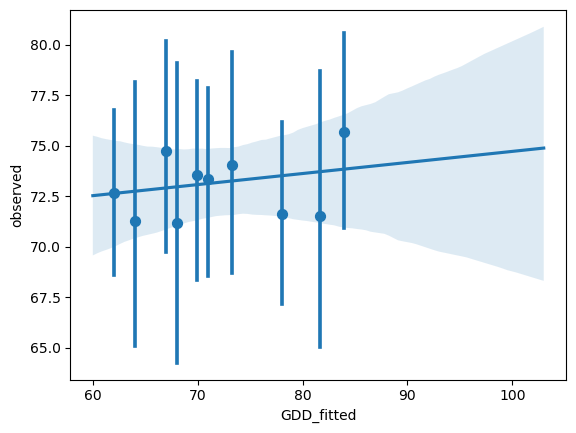

In [110]:
sns.regplot(y=datt['observed'], x=datt['GDD_fitted'],  x_bins=10)

In [88]:
no_regions_test_first['comparison_frames'][0]

,fitted,observed,Error,GDD_fitted
0,67.0,81.0,14.0,0.0
1,68.0,74.0,6.0,0.0
2,71.0,78.0,7.0,0.0
3,57.0,62.0,5.0,0.0
4,64.0,65.0,1.0,0.0
...,...,...,...,...
69,70.0,70.0,0.0,0.0
70,68.0,67.0,-1.0,0.0
71,76.0,79.0,3.0,0.0
72,77.0,97.0,20.0,0.0


In [81]:
df, df_pooled, df_full_model = make_df_from_score_dict(results_combined_test_first, TL_method='GDD', variety='combined')

In [83]:
df_pooled

,R2 score,Variety,TL method
0,0.541327,combined,GDD
1,0.302497,combined,GDD
2,0.188403,combined,GDD
3,0.345718,combined,GDD


In [45]:
ds_inputs_SSA

,Unnamed: 0,WC SOS date,Stations_id,lat,lon,Management,vargroup,Referenzjahr,t2m at day 0,t2m at day 1,...,vpd at day 190,vpd at day 191,vpd at day 192,vpd at day 193,vpd at day 194,vpd at day 195,vpd at day 196,vpd at day 197,vpd at day 198,vpd at day 199
0,0,2002-12-17,6,-5.60,12.20,Optimal,EIHY,2003,25.769745,25.896423,...,-4.279846,-4.157588,-4.682982,-4.279093,-3.935287,-4.161370,-4.629251,-5.700133,-5.429239,-5.936370
1,1,2002-12-13,6,-5.60,12.20,Low pH,EPOP,2003,25.793823,25.691589,...,-4.555864,-5.485074,-5.041852,-4.034870,-4.279846,-4.157588,-4.682982,-4.279093,-3.935287,-4.161370
2,2,2002-12-16,6,-5.60,12.20,Low pH,ILPO,2003,25.615417,25.769745,...,-4.034870,-4.279846,-4.157588,-4.682982,-4.279093,-3.935287,-4.161370,-4.629251,-5.700133,-5.429239
3,3,2004-02-21,6,-5.60,12.20,Optimal,EIHY,2004,27.028351,27.053223,...,-5.105543,-4.370707,-3.930038,-3.608394,-4.111270,-4.437978,-4.003904,-4.275821,-4.646197,-4.663238
4,4,2004-02-20,6,-5.60,12.20,Low N,EPOP,2004,25.728760,27.028351,...,-5.285736,-5.105543,-4.370707,-3.930038,-3.608394,-4.111270,-4.437978,-4.003904,-4.275821,-4.646197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,698,2004-05-15,1067,-20.35,32.33,Drought,ILHY,2004,20.395331,20.107080,...,-27.073094,-14.056051,-8.801011,-5.155993,-9.037099,-9.509027,-11.749110,-18.612149,-20.858393,-21.744746
699,699,2004-05-15,1067,-20.35,32.33,Drought,ILPO,2004,20.395331,20.107080,...,-27.073094,-14.056051,-8.801011,-5.155993,-9.037099,-9.509027,-11.749110,-18.612149,-20.858393,-21.744746
700,700,2006-05-20,1067,-20.35,32.33,Drought,EIHY,2006,23.211902,19.341736,...,-4.886220,-11.129727,-16.442254,-15.277114,-15.384368,-24.982062,-27.035905,-29.915104,-29.004011,-7.377276
701,701,2006-05-20,1067,-20.35,32.33,Drought,ILHY,2006,23.211902,19.341736,...,-4.886220,-11.129727,-16.442254,-15.277114,-15.384368,-24.982062,-27.035905,-29.915104,-29.004011,-7.377276


In [75]:
results_dict_early_justrate = K_fold_transfer_regions(early_ds_dict, transfer_method='just rate')
results_dict_early = K_fold_transfer_regions(early_ds_dict, transfer_method='all wang')
results_dict_late_justrate = K_fold_transfer_regions(late_ds_dict, transfer_method='just rate')
results_dict_late = K_fold_transfer_regions(late_ds_dict, transfer_method='all wang')

0 66.366943359375 103.53804779052734
1 63.01133346557617 95.78091430664062
2 64.00833892822266 98.48556518554688
48 63.007850646972656 103.77860260009766
49 63.008827209472656 103.79940795898438
50 63.00868225097656 104.26007843017578
51 63.0078239440918 104.46598815917969
52 63.009002685546875 104.13927459716797
98 63.007572174072266 104.14154815673828
99 63.0075798034668 104.0938720703125
100 63.00757598876953 104.08307647705078
101 63.0075798034668 104.12752532958984
102 63.00757598876953 104.13230895996094
148 63.007564544677734 104.11294555664062
149 63.00757598876953 104.10942840576172
150 63.007572174072266 104.10770416259766
151 63.007572174072266 104.11186218261719
152 63.007564544677734 104.11100006103516
198 63.007572174072266 104.11023712158203
199 63.007572174072266 104.11023712158203
200 63.007572174072266 104.10954284667969
201 63.007572174072266 104.11023712158203
202 63.007572174072266 104.11023712158203
248 63.007572174072266 104.10985565185547
249 63.007572174072266 

In [92]:
for ind, score_dict in enumerate([results_dict_early_justrate, results_dict_early, results_dict_late_justrate, results_dict_late]):
    variety = ['early', 'early', 'late', 'late'][ind]
    TL_method = ['just rate', 'all Wang', 'just rate', 'all Wang'][ind]
    df, df_pooled, df_full_model = make_df_from_score_dict(score_dict, TL_method=TL_method, variety=variety)
    df['region'] = np.array(score_dict['regions'])
    df_pooled['region'] = np.array(score_dict['regions'])
    df_full_model['region'] = 'all combined'
    df_full_model['TL method'] = TL_method
    df = pd.concat((df, df_full_model))
    df_pooled = pd.concat((df_pooled, df_full_model))
    if ind == 0:
        df_full = df
        df_pooled_full = df_pooled
    else:
        df_full = pd.concat([df_full, df])
        df_pooled_full = pd.concat([df_pooled_full, df_pooled])


In [93]:
df_full

,R2 score,Variety,TL method,region
0,0.338745,early,just rate,arid low
1,-2.132096,early,just rate,city
2,-0.059906,early,just rate,high
3,0.131749,early,just rate,humid low
0,0.118099,early,just rate,all combined
0,0.572409,early,all Wang,arid low
1,0.061416,early,all Wang,city
2,-0.016361,early,all Wang,high
3,0.398828,early,all Wang,humid low
0,0.446160,early,all Wang,all combined


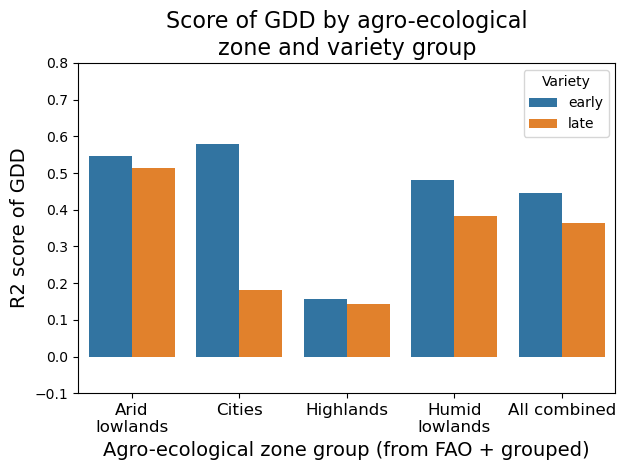

In [96]:
font_size = 14
fig, ax = plt.subplots()
sns.barplot(data = df_pooled_full.loc[df_pooled_full['TL method'] == 'all Wang'], hue = 'Variety', x = 'region', y='R2 score', ax=ax)
ax.set_xticks(range(5), ['Arid\nlowlands', 'Cities', 'Highlands', 'Humid\nlowlands', 'All combined'], fontsize =font_size - 2)
ax.set_ylabel('R2 score of GDD', fontsize =font_size)
ax.set_xlabel('Agro-ecological zone group (from FAO + grouped)', fontsize =font_size)
ax.set_title('Score of GDD by agro-ecological\nzone and variety group', fontsize = font_size +2)
ax.set_ylim((-0.1, 0.8))
fig.tight_layout()

In [82]:
results_dict_early_justrate['regions']

['arid low', 'city', 'high', 'humid low']

0 50.48228454589844 44.45783233642578
5 44.5064582824707 43.62117004394531
10 41.185218811035156 44.83407211303711
15 40.247314453125 47.70518112182617
20 40.492286682128906 48.75636291503906
25 40.345767974853516 47.75763702392578


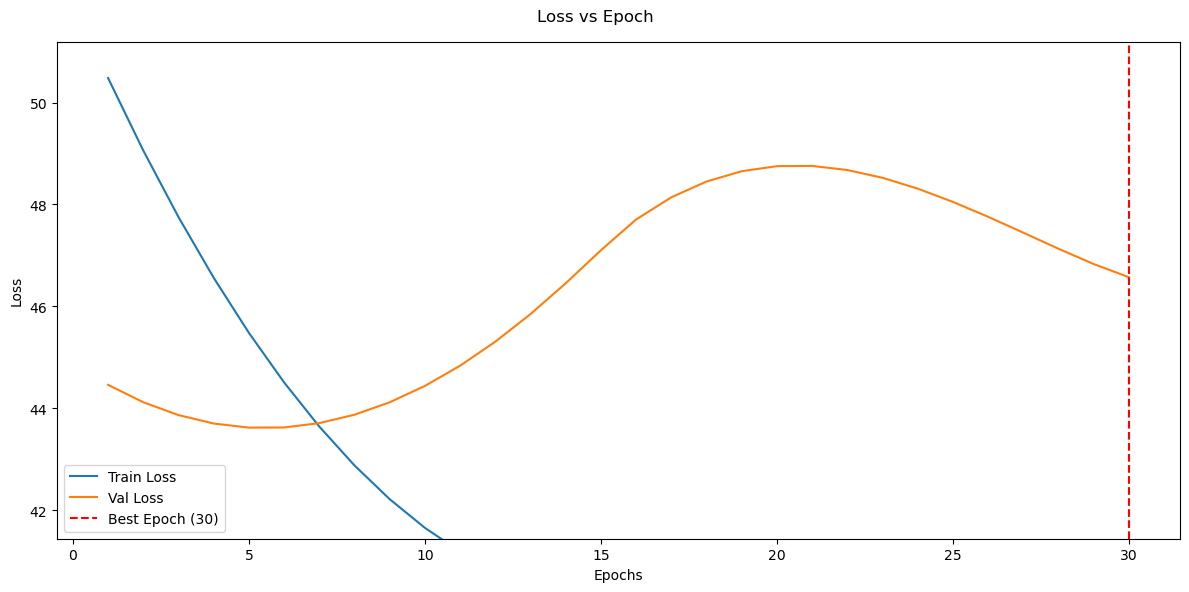

In [34]:
bs = 30000
n_channels = 5
#temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE, NDVI_series_DE)), 0, 1) #photoperiod_series_DE,
#temp_NDVI_series_DE = torch.swapaxes(temp_NDVI_series_DE, 2, 1)[2022, 2023, 2024]
#train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels, train_proportion=0.8)
train_dl, val_dl = train_test_dl_by_year(temp_NDVI_series_DE, NDVI_labels_DE, test_years = [2023, 2024], year_column = -2, bs = bs, n_channels = n_channels, train_proportion=0.8)
input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 16#day2 -> 8#day -> 16 #day3 ->4
num_layers = 4#day3 -> 8
output_dim = 1  # Example: 5 classes
KG = False
KG2 = True
save_name = 'NN_response_DE_no_day5'
model= nn_temp_response(input_dim, hidden_dim, num_layers, output_dim, KG=KG, KG2=KG2)
criterion = problist_square_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)#, weight_decay = 0.0001)
#optimizer = torch.optim.ASGD(model.parameters(), lr=0.001)
#optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
GDD_params = [0.31621224, 7.37066436, 22.88481424, 39.40562477]
model = initialise_as_GDD(model, *GDD_params, n_channels=5)
epochs = 30
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = False, bce=True)

torch.Size([939, 163]) torch.Size([939, 163, 1])
R^2 value for model: 0.3444226384162903
Bias: 3.3513643741607666
Variance of modelled values: 29.244579315185547


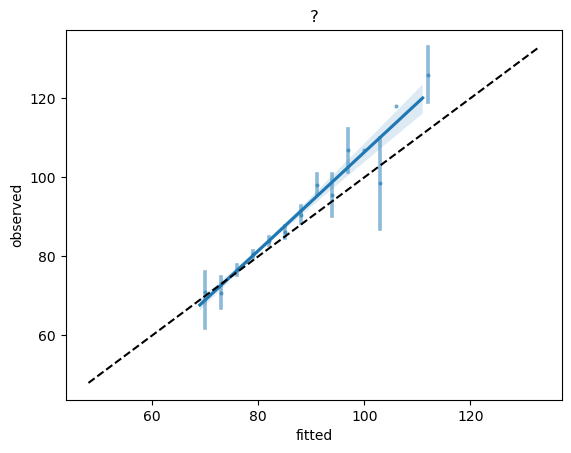

In [37]:
model = load_model(save_name, model)
with torch.no_grad():
    plot_fitted_observed_TS(model, val_dl, bce=True, CNN=False, title='?', MMD=False)

In [80]:
bs = 30000
n_channels = 5
input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 16#day2 -> 8#day -> 16 #day3 ->4
num_layers = 4#day3 -> 8
output_dim = 1  # Example: 5 classes
KG = False
KG2 = True
CNN = False
bce = True
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG, KG2)
epochs = 500
lr = 0.001
GDD_init = [[0.33255554, 7.01088182, 23.30372493, 39.15531463],
            [0.5211015 , 7.97262452, 26.93599014, 39.03618276],
            [0.32364492, 7.77869448, 23.14973298, 39.31765333],
            [0.36357164, 7.39815342, 24.93931749, 39.26584633],
            [0.3354603 , 7.12958798, 24.48095047, 39.61850868],
            [0.32169801, 7.0014374 , 23.95026893, 39.29402994]]
year_folds = [list(range(1991 + 6*n, 1991 + 6*n + 6)) for n in range(5)] + [[2021, 2022, 2023, 2024]]
loss_values, R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs = K_fold_year_crossval(year_folds, temp_NDVI_series_DE, NDVI_labels_DE, 
                                                                                                              nn_temp_response, 
                                                                                                        epochs, bs, model_args, 
                                                                                                        lr = lr, 
                                                                                                        loss = 'MSE', CNN=CNN, bce=bce, n_channels = n_channels,
                                                                                                        custom_loss=problist_square_loss, DTF = False,
                                                                                                        GDD_init=GDD_init, verbose=True)

Fold 1
[0.33255554, 7.01088182, 23.30372493, 39.15531463]
0 39.845680236816406 62.41814422607422
1 44.59663009643555 59.63982391357422
2 43.24580001831055 51.49837875366211
48 38.34069061279297 45.73033142089844
49 38.28206253051758 46.31352615356445
50 38.27458953857422 46.118492126464844
51 38.2401237487793 45.44850540161133
52 38.214447021484375 45.27507400512695
98 37.66887664794922 44.78419876098633
99 37.65564727783203 44.82259750366211
100 37.64269256591797 44.711708068847656
101 37.62919235229492 44.715511322021484
102 37.61547088623047 44.73961639404297
148 37.09388732910156 43.590782165527344
149 37.084049224853516 43.73839569091797
150 37.08033752441406 43.341861724853516
151 37.081085205078125 43.941043853759766
152 37.08573532104492 43.1374626159668
198 36.83203125 43.107784271240234
199 36.82805252075195 43.46141052246094
200 36.825294494628906 43.06086730957031
201 36.82466506958008 43.5501823425293
202 36.82730484008789 42.934391021728516
248 37.33988571166992 44.360862

In [71]:
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
bs = 30000
n_channels = 5
#temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE, NDVI_series_DE)), 0, 1) #photoperiod_series_DE,
#temp_NDVI_series_DE = torch.swapaxes(temp_NDVI_series_DE, 2, 1)[2022, 2023, 2024]
#train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels, train_proportion=0.8)
train_dl, val_dl = train_test_dl_by_year(temp_NDVI_series_DE, NDVI_labels_DE, test_years = [2023, 2024], year_column = -2, bs = bs, n_channels = n_channels, train_proportion=0.8)
input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 16#day2 -> 8#day -> 16 #day3 ->4
num_layers = 4#day3 -> 8
output_dim = 1  # Example: 5 classes
KG = False
KG2 = True
CNN = False
bce=True

model_args = (input_dim, hidden_dim, num_layers, output_dim, KG, KG2)
save_name = 'NN_response_DE_no_day5'

epochs = 300
lr=0.01
#run K-fold cross validation
criterion = problist_square_loss()
comparison_frame, loss_values, R2s, Biases, Variances, RMSEs, SSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, lengths, obsvars = K_fold_transfer(5, ds_SSA_early.rename(columns={'year': 'Referenzjahr'}), nn_temp_response, 
                                                                                                        save_name, epochs, bs, model_args, lr = lr, 
                                                                                                        loss = 'MSE', CNN=CNN, bce=bce, 
                                                                                                        custom_loss=criterion, DTF = False, all_wang=True)

0 55.48792266845703 56.93212127685547
1 54.409019470214844 55.53050994873047
29 40.1488037109375 39.3355827331543
30 39.87733459472656 39.218666076660156
31 39.61548614501953 39.107643127441406
59 34.8665771484375 36.441375732421875
60 34.75587463378906 36.37087631225586
61 34.64778137207031 36.3031120300293
89 32.38591384887695 34.9488639831543
90 32.325157165527344 34.908912658691406
91 32.26541519165039 34.869598388671875
119 30.922401428222656 34.00120544433594
120 30.883882522583008 33.975852966308594
121 30.84588623046875 33.95079040527344
149 29.9617977142334 33.36540985107422
150 29.93562889099121 33.3480224609375
151 29.90978240966797 33.330833435058594
179 29.296581268310547 32.92107009887695
180 29.278095245361328 32.90869140625
181 29.259815216064453 32.89643478393555
209 28.82052993774414 32.6008415222168
210 28.8071231842041 32.591793060302734
211 28.793851852416992 32.58281707763672
239 28.47199821472168 32.364383697509766
240 28.462085723876953 32.35761260986328
241 28.

In [72]:
np.mean(np.array(R2s))

np.float64(0.5425811648368836)

In [73]:
r2_score(comparison_frame['observed'], comparison_frame['fitted'])

0.5504122972488403

In [60]:
r2_score(comparison_frame['observed'], comparison_frame['fitted'])

0.27426183223724365

In [ ]:
bs = 30000
n_channels = 5
input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 16#day2 -> 8#day -> 16 #day3 ->4
num_layers = 4#day3 -> 8
output_dim = 1  # Example: 5 classes
KG = False
KG2 = True
CNN = False
bce = True
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG, KG2)
epochs = 500
lr = 0.001
GDD_init = [[0.33255554, 7.01088182, 23.30372493, 39.15531463],
            [0.5211015 , 7.97262452, 26.93599014, 39.03618276],
            [0.32364492, 7.77869448, 23.14973298, 39.31765333],
            [0.36357164, 7.39815342, 24.93931749, 39.26584633],
            [0.3354603 , 7.12958798, 24.48095047, 39.61850868],
            [0.32169801, 7.0014374 , 23.95026893, 39.29402994]]
year_folds = [list(range(1991 + 6*n, 1991 + 6*n + 6)) for n in range(5)] + [[2021, 2022, 2023, 2024]]
loss_values, R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs = K_fold_year_crossval(year_folds, temp_NDVI_series_DE, NDVI_labels_DE, 
                                                                                                              nn_temp_response, 
                                                                                                        epochs, bs, model_args, 
                                                                                                        lr = lr, 
                                                                                                        loss = 'MSE', CNN=CNN, bce=bce, n_channels = n_channels,
                                                                                                        custom_loss=problist_square_loss, DTF = False,
                                                                                                        GDD_init=GDD_init, verbose=True)

In [ ]:
err_df = make_error_df(R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, 'accumulated NN response', 'DE', '5-fold year CV')
err_df.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\important_results\\NEW_error_df_NN.csv')

In [77]:
GDD_params = [0.33255554, 7.01088182, 23.30372493, 39.15531463]#[0.31621224, 7.37066436, 22.88481424, 39.40562477]
model = initialise_as_GDD(model, *GDD_params, n_channels=5)

0 276.7798156738281 270.7234802246094
5 42.76600646972656 47.19794845581055
10 51.994205474853516 46.777061462402344
15 40.95277404785156 54.43132400512695
20 41.64373016357422 52.39447021484375
25 40.89780807495117 46.53742980957031


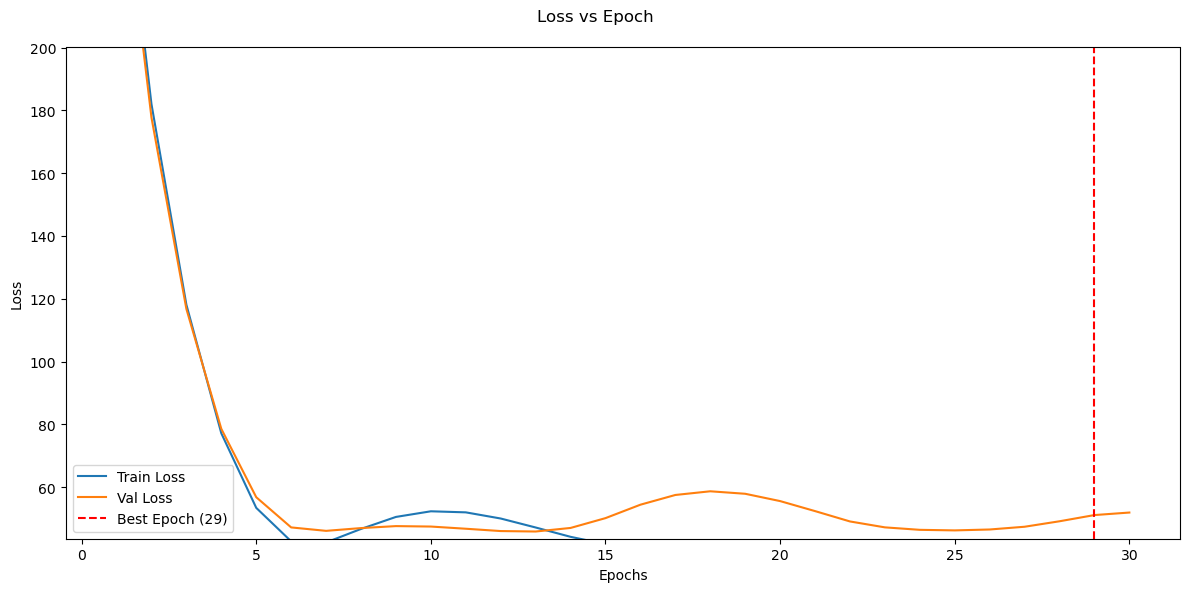

In [78]:
#for param in [model.u0, model.u1, model.u2, model.u3, model.u4, model.fc.bias]: #[model.u1, model.u2, model.u3]:
#    param.requires_grad = False
# Loss function and optimizer
criterion = nn.BCELoss() # nn.NLLLoss() # nn.BCELoss() #  # For multi-class classification
criterion = problist_square_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)#, weight_decay = 0.0001)
#optimizer = torch.optim.ASGD(model.parameters(), lr=0.001)
#optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
epochs = 30
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = False, bce=True)

torch.Size([7428, 163]) torch.Size([7428, 163, 1])
R^2 value for model: 0.3852505087852478
Bias: 13.381333351135254
Variance of modelled values: 85.81896209716797


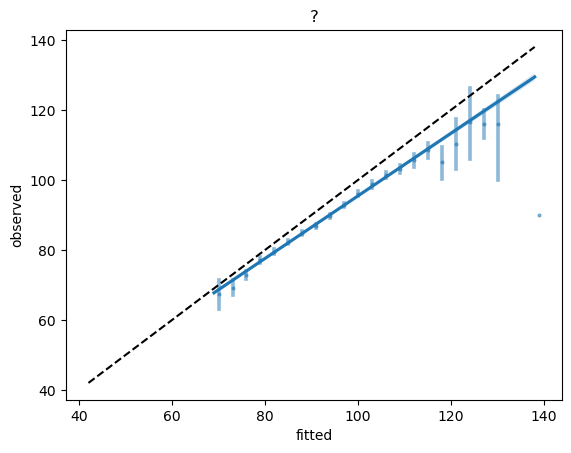

In [79]:
with torch.no_grad():
    plot_fitted_observed_TS(model, val_dl, bce=True, CNN=False, title='?', MMD=False)

0 40.165401458740234 52.97562026977539
5 38.957862854003906 44.785926818847656
10 38.52963638305664 48.39216232299805
15 38.40574264526367 44.66185760498047
20 38.263858795166016 45.8461799621582
25 38.1108283996582 45.924442291259766


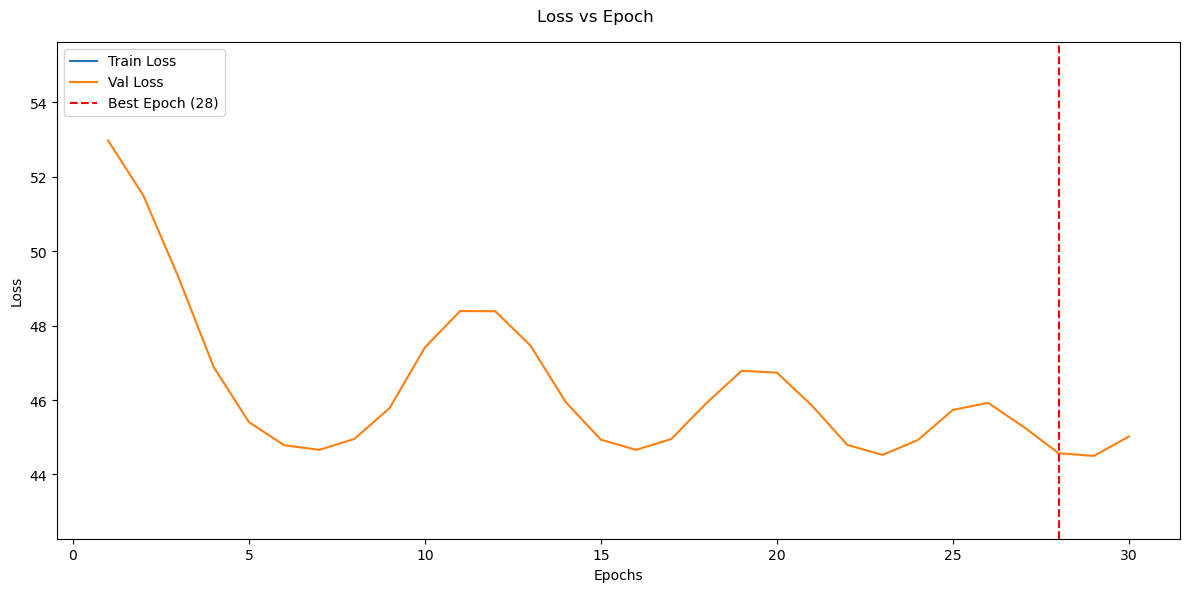

In [70]:
epochs = 30
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = False, bce=True)

In [19]:
def forward_NN_KG2(self, x0):
    with torch.no_grad():
        T_min = 9 + 10*(torch.tanh(self.u1)) - 4 #normally multiplier = 2
        T_opt = 28 + 7*(torch.tanh(self.u2)) - 4 #normally multiplier = 3
        T_max = 39 + 3.5*torch.tanh(self.u3)#normally no multiplier
        #print(T_min)
        alpha = np.log(2)/torch.log( (T_max - T_min)/(T_opt - T_min) )
        original_temp = x0[:, :, [0]]
        x2 = x0[:, :, [0]]
        x2[:, :, 0] = (x2[:, :, 0] <= T_max) * ( (2*(((x2[:, :, 0] - T_min)*(x2[:, :, 0] >= T_min) + (x2[:, :, 0] <= T_min).float()).pow(alpha))*(x2[:, :, 0] >= T_min))*((T_opt - T_min).pow(alpha)) - ((((x2[:, :, 0] - T_min)*(x2[:, :, 0] >= T_min) + (x2[:, :, 0] <= T_min).float()).pow(2*alpha))*(x2[:, :, 0] >= T_min)) ) / ((T_opt - T_min).pow(2*alpha))
        x = x0[:, :, :self.input_dim]
        for linlayer in self.layers_list[:self.num_layers]:
            x = linlayer(x)
            x = self.activation(x)
        out_space = self.u4*(torch.abs(self.fc(x) + x2)*(original_temp >5))# - x2#*(x[:, :, [0]] >5) # (batch, output_dim)

    #print(out_scores.max())
    return out_space

In [379]:
import shap
def shap_wrapper(x):
    #print(torch.tensor(x).unsqueeze(0).unsqueeze(0).float())
    if x.ndim == 1:
        input_vec = torch.tensor(x).unsqueeze(0).unsqueeze(0).float()
        return np.expand_dims(np.expand_dims(forward_NN_KG2(model, input_vec).numpy().squeeze(), 0),0)#
    elif x.ndim == 2:
        input_vec = torch.tensor(x).unsqueeze(0).float()
        if x.shape[0] == 1:
            return np.expand_dims(np.expand_dims(forward_NN_KG2(model, input_vec).numpy().squeeze(), 0), 0)
        else:
            return np.expand_dims(forward_NN_KG2(model, input_vec).numpy().squeeze(), 1)
    else:
        input_vec = torch.tensor(x).float()
        return forward_NN_KG2(model, input_vec).numpy().squeeze()

#def shap_wrapper(x):
#    #print(torch.tensor(x).unsqueeze(0).unsqueeze(0).float())
#    if x.ndim == 1:
#        input_vec = torch.tensor(x).unsqueeze(0).unsqueeze(0).float()
#        return forward_NN_KG2(model, input_vec).numpy().squeeze()
#    elif x.ndim == 2:
#        input_vec = torch.tensor(x).unsqueeze(0).float()
#        if x.shape[0] == 1:
#            return forward_NN_KG2(model, input_vec).numpy().squeeze()
#        else:
#            return forward_NN_KG2(model, input_vec).numpy().squeeze()
#    else:
#        input_vec = torch.tensor(x).float()
#        return forward_NN_KG2(model, input_vec).numpy().squeeze()
    
first = True
for xb, yb in train_dl:
    if first:
        full_xb = xb
        first = False
    else:
        full_xb = torch.cat((full_xb, xb), dim=0)
first = True
for xb, yb in val_dl:
    if first:
        full_xb_val = xb
        first = False
    else:
        full_xb_val = torch.cat((full_xb_val, xb), dim=0)

In [380]:
explainer = shap.KernelExplainer(shap_wrapper, 
                                 full_xb[[0, 2500, 5000, 7500, 10000], :].transpose(1, 2).flatten(0, 1)[:, :5].numpy(), 
                                 link="identity",
                                 feature_names=['t2m', 't2max', 't2min', 'photoperiod', 'vpd'])

Using 815 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [381]:
X_test =full_xb_val[[0, 250, 500, 750, 1000], :].transpose(1, 2).flatten(0, 1)[:, :5].numpy()#[, :]

In [382]:
shap_values = explainer.shap_values(X_test, nsamples=100)

100%|██████████| 815/815 [00:04<00:00, 194.92it/s]


In [387]:
shap_data = pd.DataFrame(shap_values[:, :, 0], columns = ['t2m', 't2max\n-t2m', 't2m\n-t2min', 'photoperiod', 'vpd'])

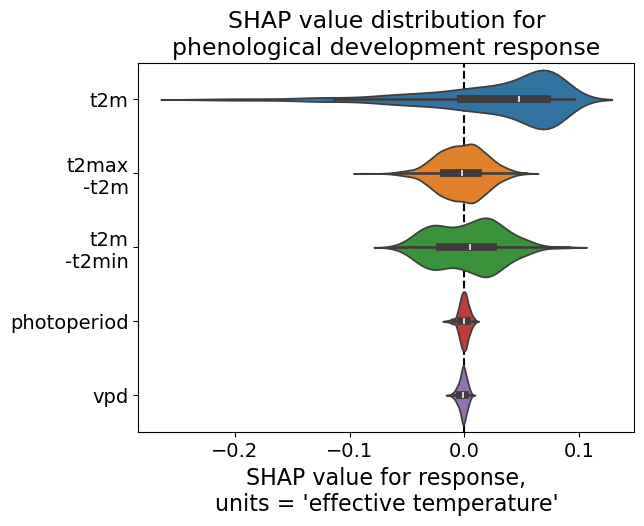

In [388]:
font_size = 14
fig, ax = plt.subplots()
sns.violinplot(data=shap_data, orient = 'h', ax=ax, zorder = 1)
ax.axvline(0, color='k', linestyle='--', zorder = 0)
ax.set_xlabel('SHAP value for response,\nunits = \'effective temperature\'', fontsize = font_size + 2)
ax.set_title('SHAP value distribution for\nphenological development response', fontsize = font_size + 3)
ax.tick_params(labelsize = font_size)

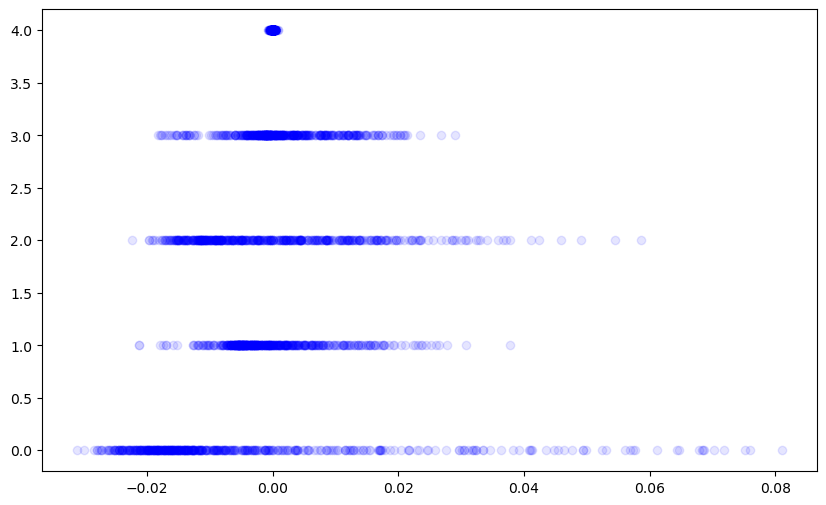

In [317]:
fig, ax = plt.subplots(figsize=(10,6))
for i in range(500):
    ax.scatter(shap_values[i, :, 0], range(5), color='blue', alpha = 0.1)

In [311]:
shap_values[:10, :, 0]#.shape

array([[ 6.82824109e-02,  2.84006422e-03, -2.31940250e-03,
         1.26184386e-03,  1.54310872e-04],
       [ 5.73895656e-02,  2.22986468e-03, -9.26346744e-03,
         1.56779006e-03,  2.68854289e-04],
       [ 7.02204582e-02, -2.51716762e-03,  6.73983606e-03,
         1.67269487e-03,  8.34354888e-05],
       [ 5.76564885e-02, -1.02558162e-02,  8.75354489e-03,
         1.53836247e-03,  1.86891816e-04],
       [ 7.18201039e-02,  4.03077936e-04,  1.68210769e-03,
         2.07918871e-03,  5.90020436e-05],
       [ 5.67805347e-02, -2.80604175e-03, -3.09014718e-03,
         3.11142573e-03,  2.42049878e-04],
       [ 6.47339784e-02,  5.15290655e-03, -1.33011703e-03,
         3.14026515e-03,  1.19270882e-04],
       [ 5.30776035e-02, -5.31429195e-03, -2.22170711e-03,
         3.81032741e-03,  3.38084897e-04],
       [ 4.98515230e-02, -2.80320597e-05, -8.02876097e-03,
         4.45297730e-03,  2.36533260e-04],
       [ 6.78365679e-02, -2.97004861e-03,  3.05518177e-03,
         3.84831299e-03

In [300]:
#shap.force_plot(explainer.expected_value[0], shap_values[0], X_test, link="identity", matplotlib=True)

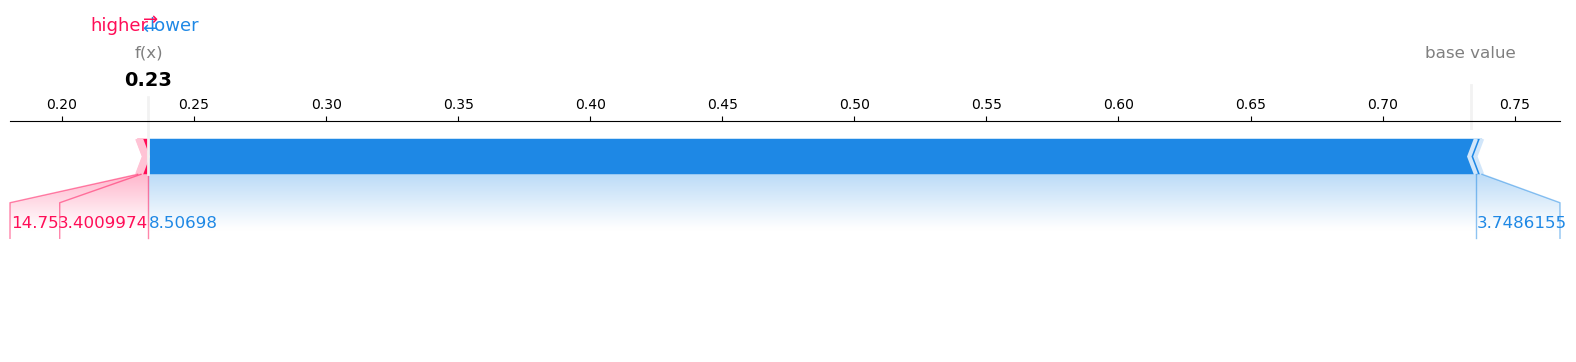

In [ ]:
shap.force_plot(explainer.expected_value[0], shap_values[0][:, 0], X_test[0,:], link="identity", matplotlib=True)

In [260]:
temp_NDVI_series_DE[0, :, 0]

tensor([ 1.1808e+01,  4.9365e+00,  3.4712e+00,  1.5317e+01, -9.1753e-02,
         0.0000e+00,  2.0040e+03,  7.5040e+03])

In [42]:
shap_wrapper(temp_NDVI_series_DE[0, :, 0].numpy())

array(0.5163244, dtype=float32)

In [46]:
full_xb.transpose(1, 2).flatten(0, 1).shape

torch.Size([4188285, 8])

In [266]:
shap_wrapper(full_xb.transpose(1, 2).flatten(0, 1)[0, :].numpy())

array(0.4363166, dtype=float32)

In [244]:
first_obs = temp_NDVI_series_DE[[0], :, :]
shap_wrapper(first_obs[:, :, [0]])

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_16856\2159168050.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return forward_NN_KG2(model, torch.tensor(x).transpose(1, 2)).numpy().squeeze()


array(0.4363166, dtype=float32)

In [237]:
temp_NDVI_series_DE[[0], :, [0]].shape

torch.Size([1, 8])

In [269]:
full_xb.transpose(1, 2).flatten(0, 1).numpy().tolist()

[[11.807905197143555,
  4.936478137969971,
  3.4711644649505615,
  15.316666603088379,
  -0.09175340831279755,
  0.0,
  2004.0,
  7504.0],
 [12.635268211364746,
  3.4315671920776367,
  3.3512024879455566,
  15.383333206176758,
  -0.0629304051399231,
  0.10000000149011612,
  2004.0,
  7504.0],
 [12.385751724243164,
  1.7562936544418335,
  2.2121920585632324,
  15.449999809265137,
  -0.038498375564813614,
  0.20000000298023224,
  2004.0,
  7504.0],
 [12.088725090026855,
  4.213867664337158,
  3.832958459854126,
  15.516666412353516,
  -0.04132508486509323,
  0.30000001192092896,
  2004.0,
  7504.0],
 [12.15213680267334,
  1.7578164339065552,
  1.987287163734436,
  15.583333015441895,
  -0.04789603874087334,
  0.4000000059604645,
  2004.0,
  7504.0],
 [10.992865562438965,
  1.2796375751495361,
  1.5075225830078125,
  15.649999618530273,
  -0.07600841671228409,
  0.5,
  2004.0,
  7504.0],
 [13.131155967712402,
  4.296525478363037,
  3.789597749710083,
  15.683333396911621,
  -0.05716870725

In [254]:
full_xb_val.shape

torch.Size([1448, 8, 163])

In [94]:
model.fc.weight.data

tensor([[1., 0., 0., 0.]])

In [221]:
model.layer12.weight.data

tensor([[1., 0.],
        [0., 1.]])

In [111]:
#epochs = 20
#fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = False, bce=True)

torch.Size([7428, 163]) torch.Size([7428, 163, 1])
R^2 value for model: 0.41930484771728516
Bias: 9.734131813049316
Variance of modelled values: 70.65897369384766


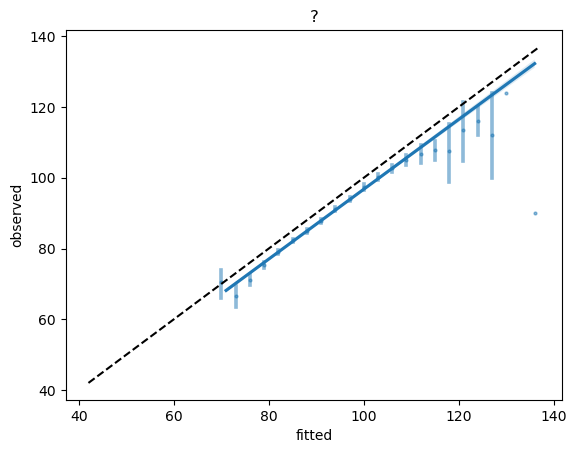

In [ ]:
with torch.no_grad():
    plot_fitted_observed_TS(model, val_dl, bce=True, CNN=False, title='?', MMD=False)

In [97]:
import copy
temp_NDVI_series_DE2 = copy.deepcopy(temp_NDVI_series_DE)
temp_NDVI_series_DE2[:, :-2, :] += torch.tensor(np.random.normal(0, 0.5, (temp_NDVI_series_DE2.shape[0], temp_NDVI_series_DE2.shape[1] - 2, temp_NDVI_series_DE2.shape[2])))
#temp_NDVI_series_DE2[:, 0, :] += torch.tensor(np.random.normal(0, 1, (temp_NDVI_series_DE2.shape[0], temp_NDVI_series_DE2.shape[2])))

In [98]:
temp_NDVI_series_DE_new = torch.concat((temp_NDVI_series_DE, temp_NDVI_series_DE2), dim=0)
NDVI_labels_DE_new = torch.concat((NDVI_labels_DE, NDVI_labels_DE), dim=0)

In [29]:
bs = 500
n_channels = 5
#temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE, NDVI_series_DE)), 0, 1) #photoperiod_series_DE,
#temp_NDVI_series_DE = torch.swapaxes(temp_NDVI_series_DE, 2, 1)
#train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels, train_proportion=0.8)
train_dl, val_dl = train_test_dl_by_year(temp_NDVI_series_DE, NDVI_labels_DE, test_years = [2022, 2023, 2024], year_column = -2, bs = bs, n_channels = n_channels, train_proportion=0.8)
input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 4#day2 -> 8#day -> 16 #day3 ->4
num_layers = 8#day3 -> 8
output_dim = 1  # Example: 5 classes
KG = False

save_name= 'NN_response_DE_no_day5'#'NN_response_DE'

model = nn_temp_response(input_dim, hidden_dim, num_layers, output_dim, KG = KG)
for param in [model.u0, model.u4]: #[model.u1, model.u2, model.u3]:
    param.requires_grad = False

# Loss function and optimizer
criterion = nn.BCELoss() # nn.NLLLoss() # nn.BCELoss() #  # For multi-class classification
criterion = problist_square_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)#, weight_decay = 0.0001)
#optimizer = torch.optim.ASGD(model.parameters(), lr=0.001)
#optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
epochs = 500
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = False, bce=True)

0 7755.9344549644875 6899.827120111792


KeyboardInterrupt: 

In [100]:
train_dl, val_dl_old = train_test_dl_by_year(temp_NDVI_series_DE, NDVI_labels_DE, test_years = [2022, 2023, 2024], year_column = -2, bs = bs, n_channels = n_channels, train_proportion=0.8)

OrderedDict([('u0', tensor([200.])), ('u1', tensor([0.])), ('u2', tensor([0.])), ('u3', tensor([0.])), ('u4', tensor([50.])), ('p0', tensor([13.])), ('lstm.weight_ih_l0', tensor([[-1.1324e-01, -7.6590e-02, -3.8780e-02, -1.4693e-01,  1.0930e-01],
        [-3.2798e-02, -3.1632e-03, -1.0555e-02, -1.7551e-01,  3.2250e-02],
        [ 6.0203e-02,  1.2229e-01, -7.7857e-02, -1.0692e-01, -1.3647e-01],
        [-1.0210e-01,  1.2253e-01, -1.4263e-01,  6.7163e-02,  5.8810e-02],
        [ 1.1424e-01,  8.3513e-02,  1.0089e-01,  2.6344e-03, -3.6682e-02],
        [ 1.2123e-01,  1.5455e-01,  1.5735e-01,  7.7015e-02, -1.7165e-01],
        [ 1.2805e-02,  1.0339e-01,  1.0315e-02,  2.7381e-02,  1.6310e-01],
        [-9.7656e-02,  1.4042e-01,  7.5368e-02, -3.4083e-02, -5.2849e-02],
        [-1.1178e-01,  8.3761e-02, -7.0898e-02,  1.4139e-01, -8.1721e-02],
        [-1.4767e-01, -1.5896e-01, -7.2926e-04,  4.5433e-02,  1.0430e-01],
        [ 1.0104e-01, -1.6777e-01,  5.3025e-02,  1.5723e-01,  4.8288e-02],
    

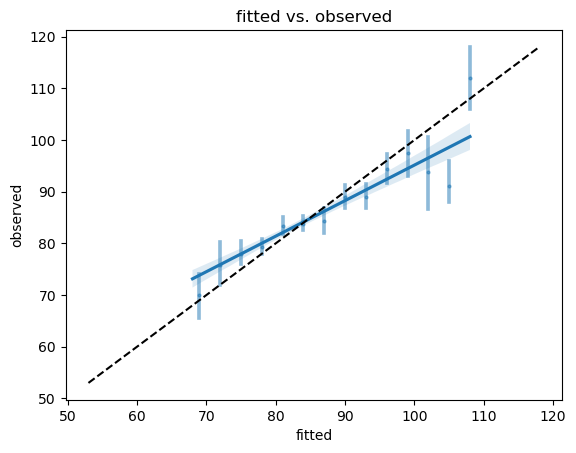

In [101]:
#save_name= 'NN_response_DE_no_day4'
plot_from_saved(save_name, model, val_dl_old, method = 'regression', bce=True, CNN=False)#

In [29]:
bs = 30000
n_channels = 5

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 16
num_layers = 4
output_dim = 1  # Example: 5 classes
bce = True
CNN = False
KG = False
KG2 = True

epochs = 2#500
#train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
k_folds = 5
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG, KG2)

model_class = nn_temp_response

year_folds = [list(range(1991 + 6*n, 1991 + 6*n + 6)) for n in range(5)] + [[2021, 2022, 2023, 2024]]

loss_values, R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs = K_fold_year_crossval(year_folds, temp_NDVI_series_DE, NDVI_labels_DE, model_class, epochs, bs, model_args, savename_prefix = 'KFold', freeze_params=True, loss='MSE', custom_loss=problist_square_loss, bce=bce, CNN=CNN, lr = 0.001)

Fold 1
torch.Size([7428, 163]) torch.Size([7428, 163, 1])
Fold 2
torch.Size([5232, 163]) torch.Size([5232, 163, 1])
Fold 3
torch.Size([4697, 163]) torch.Size([4697, 163, 1])
Fold 4
torch.Size([4191, 163]) torch.Size([4191, 163, 1])
Fold 5
torch.Size([3594, 163]) torch.Size([3594, 163, 1])
Fold 6
torch.Size([2001, 163]) torch.Size([2001, 163, 1])


In [30]:
R2s

[0.46236133575439453,
 -7.873197555541992,
 0.4039318561553955,
 -0.6661123037338257,
 0.47218644618988037,
 0.38663971424102783]

In [ ]:
score = np.mean(loss_values_raw)
score_stde = np.std(loss_values_raw)/np.sqrt(5)
R2_score = np.mean(R2s_raw)
R2_stde = np.std(R2s_raw)/np.sqrt(5)
Bias_score = np.mean(np.array(Biases_raw)**2)
Bias_stde = np.std(np.array(Biases_raw)**2)/np.sqrt(5)
Variance_score = np.mean(Variances_raw)
Variance_stde = np.std(Variances_raw)/np.sqrt(5)
print(f'#### simple nn model SSA ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}\nBias {Bias_score} +/- {Bias_stde}\nVariance {Variance_score} +/- {Variance_stde}')

In [14]:
loss_values_outlier = np.array(loss_values_raw)[[0, 1, 3, 4]]
R2s_outlier = np.array(R2s_raw)[[0, 1, 3, 4]]
Biases_outlier = np.array(Biases_raw)[[0, 1, 3, 4]]
Variances_outlier = np.array(Variances_raw)[[0, 1, 3, 4]]
score = np.mean(loss_values_outlier)
score_stde = np.std(loss_values_outlier)/np.sqrt(5)
R2_score = np.mean(R2s_outlier)
R2_stde = np.std(R2s_outlier)/np.sqrt(5)
Bias_score = np.mean(np.array(Biases_outlier)**2)
Bias_stde = np.std(np.array(Biases_outlier)**2)/np.sqrt(5)
Variance_score = np.mean(Variances_outlier)
Variance_stde = np.std(Variances_outlier)/np.sqrt(5)
print(f'#### simple nn model ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}\nBias {Bias_score} +/- {Bias_stde}\nVariance {Variance_score} +/- {Variance_stde}')

#### simple nn model ####
loss 0.08158170132949823 +/- 0.0011735902870786945
R2 0.539517268538475 +/- 0.009512910996988278
Bias 1.4095807075500488 +/- 0.4881840389611978
Variance 69.87857913970947 +/- 1.9365423397382626


In [16]:
score = np.mean(loss_values_raw)
score_stde = np.std(loss_values_raw)/np.sqrt(5)
R2_score = np.mean(R2s_raw)
R2_stde = np.std(R2s_raw)/np.sqrt(5)
Bias_score = np.mean(np.array(Biases_raw)**2)
Bias_stde = np.std(np.array(Biases_raw)**2)/np.sqrt(5)
Variance_score = np.mean(Variances_raw)
Variance_stde = np.std(Variances_raw)/np.sqrt(5)
print(f'#### simple nn model ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}\nBias {Bias_score} +/- {Bias_stde}\nVariance {Variance_score} +/- {Variance_stde}')

#### simple nn model ####
loss 0.0857873895036034 +/- 0.0017501291191818161
R2 0.5025057911872863 +/- 0.03304838901787813
Bias 5.320456504821777 +/- 2.65924510467014
Variance 65.17378997802734 +/- 2.6935101650037243


In [15]:
bs = 250
n_channels = 4

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8
num_layers = 4
output_dim = 1  # Example: 5 classes
bce = True
CNN = False
KG = False

epochs = 2500
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
k_folds = 5
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG)

model_class = nn_temp_response

loss_values_raw, R2s_raw, Biases_raw, Variances_raw = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, model_args, savename_prefix = 'KFold', freeze_params=True, loss='BCE', bce=bce, CNN=CNN, lr = 0.001)

Fold 1
Loss: 0.10632183402776718
Fold 2
Loss: 0.10671341419219971
Fold 3
Loss: 0.07519201934337616
Fold 4
Loss: 0.09973899275064468
Fold 5
Loss: 0.09799212962388992


In [16]:
score = np.mean(loss_values_raw)
score_stde = np.std(loss_values_raw)/np.sqrt(5)
R2_score = np.mean(R2s_raw)
R2_stde = np.std(R2s_raw)/np.sqrt(5)
Bias_score = np.mean(np.array(Biases_raw)**2)
Bias_stde = np.std(np.array(Biases_raw)**2)/np.sqrt(5)
Variance_score = np.mean(Variances_raw)
Variance_stde = np.std(Variances_raw)/np.sqrt(5)
print(f'#### simple nn model SSA ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}\nBias {Bias_score} +/- {Bias_stde}\nVariance {Variance_score} +/- {Variance_stde}')

#### simple nn model SSA ####
loss 0.1493362158536911 +/- 0.054862736700971436
R2 0.4223050832748413 +/- 0.06124715833323278
Bias 3.0792195796966553 +/- 1.7015497732485039
Variance 74.30063247680664 +/- 10.535685162350985


In [19]:
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
epochs = 3000
KG = False
regression = False
bs = 500
n_channels = 4

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8
num_layers = 4
output_dim = 1 
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG)
loss_values, R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs = K_fold_crossval(5, train_ds, nn_temp_response, epochs, bs, model_args, lr = 0.01, loss = 'MSE', CNN=False, bce=True, custom_loss=criterion, DTF = False, obs_method=False)

Fold 1
Loss: 0.08006106317043304
torch.Size([51, 163]) torch.Size([51, 163, 1])
Fold 2
Loss: 0.08299506455659866
torch.Size([51, 163]) torch.Size([51, 163, 1])
Fold 3
Loss: 0.091669462621212
torch.Size([51, 163]) torch.Size([51, 163, 1])
Fold 4
Loss: 0.08720815926790237
torch.Size([51, 163]) torch.Size([51, 163, 1])
Fold 5
Loss: 0.0792701467871666
torch.Size([50, 163]) torch.Size([50, 163, 1])


In [35]:
err_df = make_error_df(R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, 'accumulated NN response', 'SSA', 'Transfer DE to SSA')

In [37]:
error_df_full = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\important_results\\error_df.csv')
err_df_full = pd.concat([error_df_full, err_df], ignore_index=True)
err_df_full.drop(['Unnamed: 0'], axis = 1, inplace = True)
err_df_full.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\important_results\\error_df.csv')

In [39]:
ds_inputs_SSA['observed time to beginning of flowering'].std()

12.342406717455804

0 0.20070478320121765 0.1972217857837677
5 0.17222975194454193 0.26452574133872986
10 0.1203250139951706 0.21172836422920227
15 0.1254911869764328 0.13188336789608002
20 0.10819168388843536 0.10779127478599548
25 0.10717657953500748 0.12595246732234955
30 0.10609320551156998 0.1459871083498001
35 0.10350611060857773 0.13650380074977875
40 0.10435164719820023 0.12099400162696838
45 0.10372642427682877 0.11523743718862534
50 0.10306055843830109 0.11556493490934372
55 0.10298377275466919 0.11853209882974625
60 0.10287643224000931 0.1212286576628685
65 0.1025882214307785 0.12190330028533936
70 0.10247145593166351 0.12152165174484253
75 0.10224862396717072 0.12180918455123901
80 0.10206149518489838 0.1208568811416626
85 0.10182983428239822 0.11823616921901703
90 0.10154758393764496 0.1155490130186081
95 0.10090300440788269 0.13161486387252808
100 0.10082988440990448 0.10060412436723709
105 0.10111568123102188 0.10539599508047104
110 0.10087910294532776 0.10889188200235367
115 0.099609002470

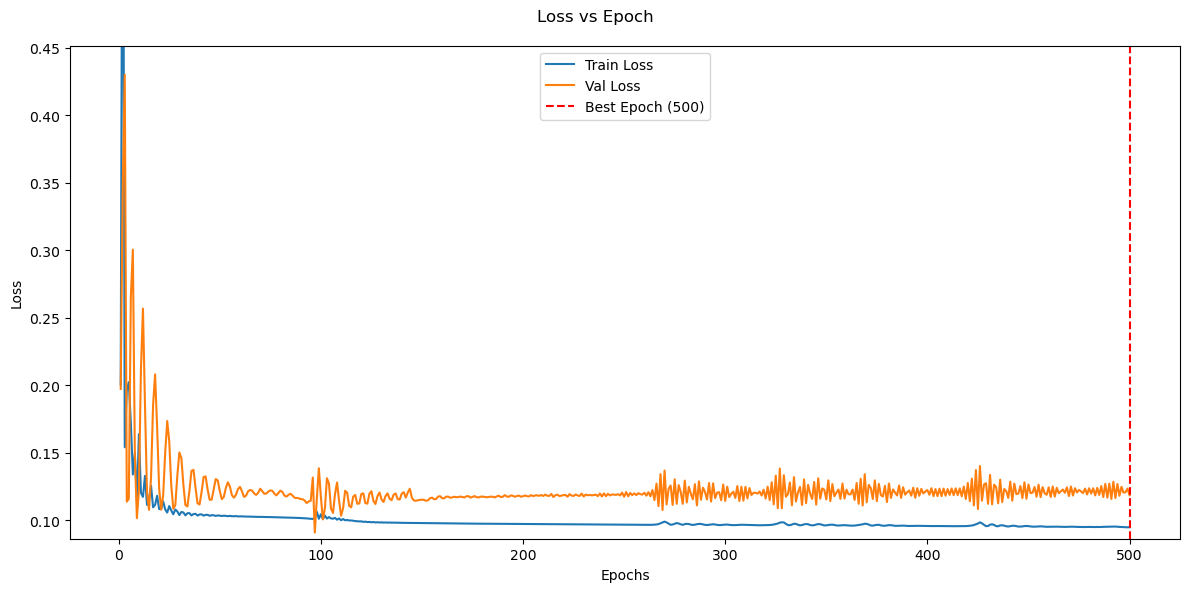

In [ ]:
bs = 500
n_channels = 5
#temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE, NDVI_series_DE)), 0, 1) #photoperiod_series_DE,
#temp_NDVI_series_DE = torch.swapaxes(temp_NDVI_series_DE, 2, 1)
train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.99)

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 16
num_layers = 4
output_dim = 1  # Example: 5 classes
KG = False

save_name= 'NN_response_SSA_no_day3'#'NN_response_DE'

model = nn_temp_response(input_dim, hidden_dim, num_layers, output_dim, KG = KG)
for param in [model.u0]: #[model.u1, model.u2, model.u3]:
    param.requires_grad = False

# Loss function and optimizer
criterion = nn.BCELoss() # nn.NLLLoss() # nn.BCELoss() #  # For multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 500
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = False, bce=True)

torch.Size([251, 163]) torch.Size([251, 163, 1])
R^2 value for model: 0.532931923866272
Bias: 0.042918819934129715
Variance of modelled values: 77.2651596069336


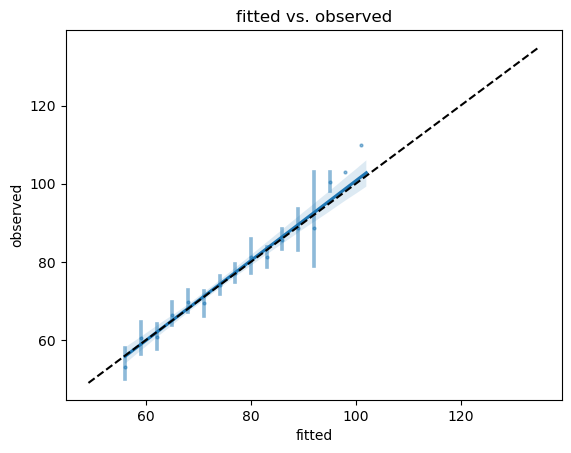

In [133]:
plot_from_saved(save_name, model, train_dl, method = 'regression', bce=True, CNN=False)#

0 75.45345978923382 60.34364424520017
5 76.41149509813702 67.91208019144175
10 79.82674916139905 93.11507824970838
15 67.50074595926243 57.229320128914885
20 72.90265138280556 55.89584771027031
25 69.63979791810851 57.24254336853627
30 69.18970425218477 55.90380017743364
35 77.83069450258165 55.58332656830373
40 73.50829431801414 55.425083182883874
45 68.26317715797937 56.95381590238021


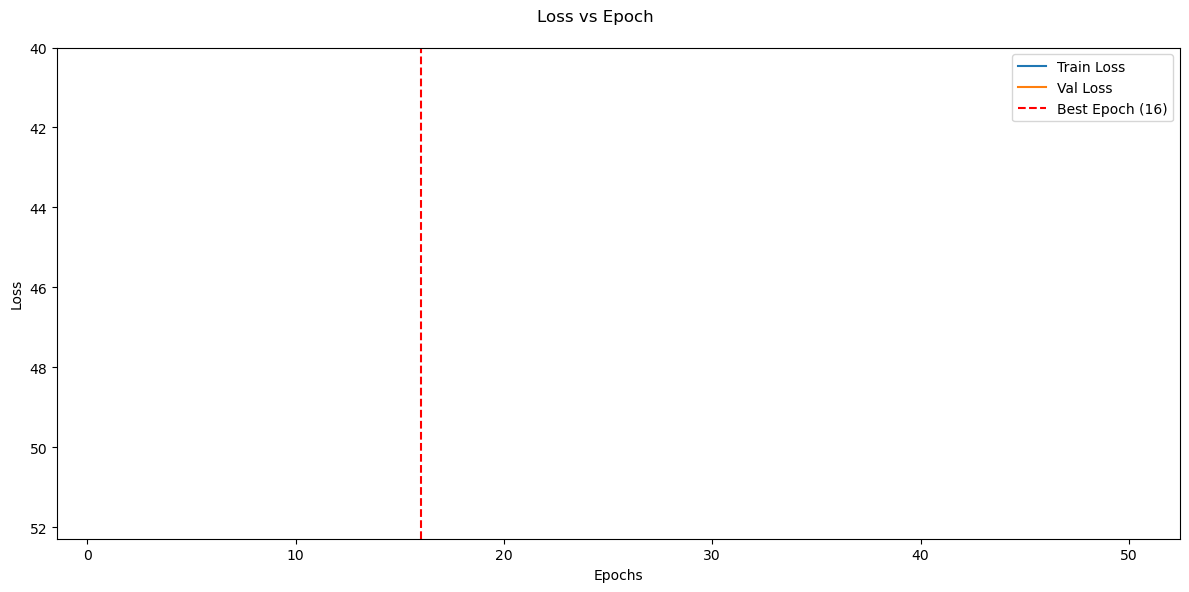

In [ ]:
#epochs = 50
#fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = False, bce=True)

OrderedDict([('u0', tensor([200.])), ('u1', tensor([0.])), ('u2', tensor([0.])), ('u3', tensor([0.])), ('u4', tensor([10.])), ('p0', tensor([13.])), ('lstm.weight_ih_l0', tensor([[ 0.2146, -0.1149, -0.2991,  0.3260,  0.1481],
        [ 0.0802,  0.2714, -0.3409,  0.2907,  0.2163],
        [-0.2066,  0.0636, -0.3385, -0.0745, -0.0090],
        [ 0.1823,  0.2823,  0.0117,  0.0856, -0.3232],
        [ 0.2043, -0.2844,  0.2926,  0.2167,  0.2795],
        [-0.0639, -0.1868,  0.1644,  0.0408,  0.1877],
        [-0.2122,  0.1931, -0.2324,  0.3330, -0.3037],
        [ 0.2220,  0.0172, -0.1483, -0.0091,  0.0582],
        [ 0.0425,  0.1096, -0.2036, -0.1354,  0.0690],
        [ 0.1589,  0.3106,  0.1300, -0.3463,  0.1701],
        [-0.3021,  0.0738,  0.2999,  0.3085,  0.0983],
        [ 0.1786, -0.3324, -0.0186, -0.1306,  0.0458],
        [-0.2464,  0.3386,  0.3332,  0.2225,  0.0312],
        [ 0.0353, -0.1375, -0.1934, -0.3207, -0.2343],
        [ 0.3027,  0.1714,  0.1431,  0.0656,  0.0389],
    

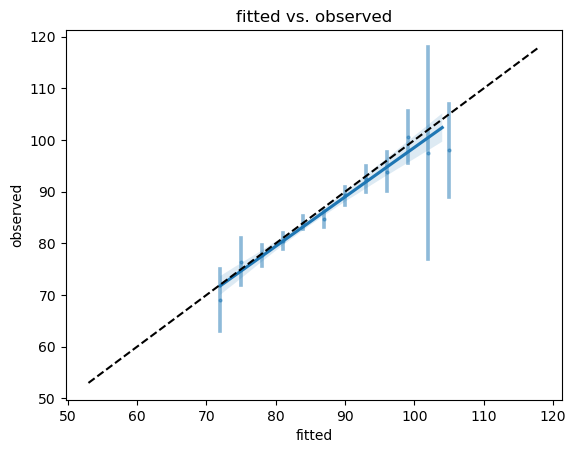

In [26]:
#save_name= 'NN_response_DE_no_day4'
plot_from_saved(save_name, model, val_dl, method = 'regression', bce=True, CNN=False)#

In [40]:
def get_comp_frame(savename, model, dl, bce=False, CNN=False, title = 'fitted vs. observed', MMD = False):
    model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
    model_path = os.path.join(model_dir, savename + ".pt")
    checkpoint = torch.load(model_path, weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    TS_model = model
    list_logs = []
    list_observed = []
    for xb, yb in dl:
        with torch.no_grad():
            if CNN:
                if MMD:
                    list_logs.append(TS_model(xb)[0])
                else:
                    list_logs.append(TS_model(xb))
            else:
                list_logs.append(TS_model(xb.transpose(1, 2)))
            #print(TS_model(xb.transpose(1, 2)))
        list_observed.append(yb)
    logs = torch.squeeze(torch.cat(list_logs))
    print(logs.shape, torch.cat(list_logs, dim=0).shape)
    if bce:
        fitted = torch.round(logs)
    else:
        fitted = torch.argmax(logs, dim=2)
    L = fitted.shape[1]
    fitted_days = L - fitted.sum(dim=1)
    observed = torch.cat(list_observed)
    observed_days = L - observed.sum(dim=1)
    comparison_frame = pd.DataFrame({'fitted': fitted_days.numpy().squeeze(), 'observed': observed_days.numpy().squeeze()})
    return comparison_frame
    

In [18]:
cf = get_comparison_frame(save_name, model, val_dl, bce=True, CNN=False)#

In [20]:
cf['fitted'].std()

6.263402938842773

In [55]:
save_name= 'NN_response_DE_no_day2'#'NN_response_DE'
model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
model_path = os.path.join(model_dir, save_name + ".pt")
checkpoint = torch.load(model_path, weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [28]:
def forward_NN(self, x0):
    x = x0[:, :, :self.input_dim]
    original_temp = x0[:, :, [0]]
    for i, linlayer in enumerate(self.layers_list[:self.num_layers]):
        x = linlayer(x)
        x = self.activation(x)
        #print(x.shape)
    # Classify all layers using fully connected layer
    out_space = torch.abs(self.fc(x))*(original_temp >5)#*(x[:, :, [0]] >5) # (batch, output_dim)

    #print(out_scores.max())
    return out_space

In [39]:
def forward_NN_KG2(self, x0):
    with torch.no_grad():
        T_min = 9 + 10*(torch.tanh(self.u1)) - 4 #normally multiplier = 2
        T_opt = 28 + 7*(torch.tanh(self.u2)) - 4 #normally multiplier = 3
        T_max = 39 + 3.5*torch.tanh(self.u3)#normally no multiplier
        #print(T_min)
        alpha = np.log(2)/torch.log( (T_max - T_min)/(T_opt - T_min) )
        original_temp = x0[:, :, [0]]
        x2 = x0[:, :, [0]]
        x2[:, :, 0] = (x2[:, :, 0] <= T_max) * ( (2*(((x2[:, :, 0] - T_min)*(x2[:, :, 0] >= T_min) + (x2[:, :, 0] <= T_min).float()).pow(alpha))*(x2[:, :, 0] >= T_min))*((T_opt - T_min).pow(alpha)) - ((((x2[:, :, 0] - T_min)*(x2[:, :, 0] >= T_min) + (x2[:, :, 0] <= T_min).float()).pow(2*alpha))*(x2[:, :, 0] >= T_min)) ) / ((T_opt - T_min).pow(2*alpha))
        x = x0[:, :, :self.input_dim]
        for linlayer in self.layers_list[:self.num_layers]:
            x = linlayer(x)
            x = self.activation(x)
        out_space = self.u4*torch.abs(self.fc(x) + x2)*(original_temp >5)#*(x[:, :, [0]] >5) # (batch, output_dim)

    #print(out_scores.max())
    return out_space - x2, x2

In [299]:
input_x[0, :, 20]

tensor([10.0000, 15.0000,  5.0000, 14.8586, -0.1061,  5.0000,  1.0000,  1.0000])

In [201]:
for experiment_index in range(5):
    sample_index = np.random.randint(0, input_tensor.shape[0])
    day_index = np.random.randint(0, temp_NDVI_series_DE.shape[2])
    input_x[0, 1, :] = input_tensor[sample_index, 1, day_index]
    input_x[0, 2, :] = input_tensor[sample_index, 2, day_index]
    input_x[0, 3, :] = input_tensor[sample_index, 3, day_index]
    input_x[0, 4, :] = input_tensor[sample_index, 4, day_index]
    input_x[0, 5, :] = input_tensor[sample_index, 5, day_index]
    print(input_x[0, :, 0])
    with torch.no_grad():
        print(trained_model.forward(input_x.transpose(1, 2)).shape)

tensor([ 0.0000,  2.7655,  1.4483, 14.7833, -0.1106,  2.3000,  1.0000,  1.0000])
torch.Size([1, 100, 1])
tensor([ 0.0000,  2.9238,  2.2434, 14.4500, -0.0657, 10.2000,  1.0000,  1.0000])
torch.Size([1, 100, 1])
tensor([ 0.0000,  3.2577,  2.7358, 15.6667, -0.1263,  3.6000,  1.0000,  1.0000])
torch.Size([1, 100, 1])
tensor([ 0.0000,  2.4210,  2.2749, 15.4167, -0.0732, 10.6000,  1.0000,  1.0000])
torch.Size([1, 100, 1])
tensor([ 0.0000,  2.8748,  2.0491, 11.6667, -0.0778, 13.9000,  1.0000,  1.0000])
torch.Size([1, 100, 1])


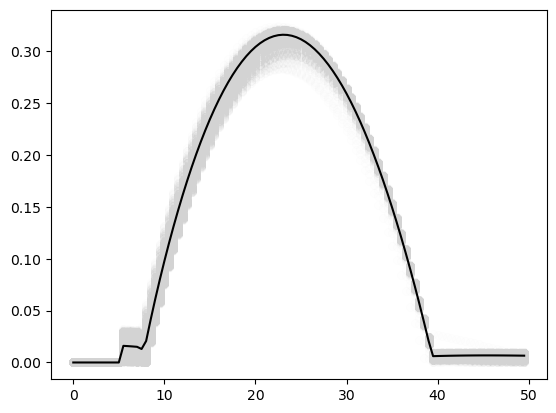

In [40]:
fig, ax = plt.subplots()
input_tensor = temp_NDVI_series_DE
input_x = torch.ones((1, 8, 100))
for vble_index in range(0, 5):
    input_x[0, vble_index, :] = input_tensor[:, vble_index, :].mean()#.quantile(0.75)
for i, T in enumerate(np.arange(0, 50, 0.5)):
    input_x[0, 0, i] = T
#    input_x[0, 1, i] = T + 5
#    input_x[0, 2, i] = T - 5
#for i, T in enumerate(np.linspace(-0.3, 0, 100)):#np.arange(-0.3, 0, 0.05)):
#    input_x[0, 4, i] = T
#    input_x[0, 4, i] = T + 0.05
#    input_x[0, 5, i] = T - 0.05
#for i, day in enumerate(np.arange(0, 100, 1)):
#    input_x[0, 5, i] = day
vals_list = []
for experiment_index in range(500):
    sample_index = np.random.randint(0, input_tensor.shape[0])
    day_index = np.random.randint(0, temp_NDVI_series_DE.shape[2])
    input_x[0, 1, :] = input_tensor[sample_index, 1, day_index]
    input_x[0, 2, :] = input_tensor[sample_index, 2, day_index]
    input_x[0, 3, :] = input_tensor[sample_index, 3, day_index]
    input_x[0, 4, :] = input_tensor[sample_index, 4, day_index]
    input_x[0, 5, :] = input_tensor[sample_index, 5, day_index]
    #print(input_x[0, 1, 0], input_x[0, 2, 0],input_x[0, 3, 0], input_x[0, 4, 0], input_x[0, 5, 0])
    #temp_pert = np.abs(np.random.normal(0, 1)*5)
    #temp_pert = input_tensor[sample_index, 1, day_index] - input_tensor[sample_index, 0, day_index]
    #if experiment_index % 50 == 0:
    #    print(temp_pert)
    #input_x[0, 1, :] = input_x[0, 0, :] + temp_pert
    #input_x[0, 2, :] = input_x[0, 0, :] - temp_pert
    with torch.no_grad():
        vals, x2 = forward_NN_KG2(model, input_x.transpose(1, 2))
        #print(vals)
    vals_list.append(vals.numpy().squeeze())
    ax.scatter(np.arange(0, 50, 0.5), vals.numpy().squeeze() + x2.squeeze().numpy(), color = 'lightgrey', alpha = 0.005)
for vble_index in range(3, 6):
    input_x[0, vble_index, :] = input_tensor[:, vble_index, :].mean()#.quantile(0.75)
input_x[0, 5, :] = day_index
temp_pert = 5#np.abs(np.random.normal(0, 1)*10)
input_x[0, 1, :] = input_x[0, 0, :] + temp_pert
input_x[0, 2, :] = input_x[0, 0, :] - temp_pert
with torch.no_grad():
    vals, x2 = forward_NN_KG2(model, input_x.transpose(1, 2))
#vals = np.array(vals).squeeze()
vals = np.mean(np.array(vals_list), axis=0)
vals_spread = np.std(np.array(vals_list), axis=0)
vals_LQ = np.quantile(np.array(vals_list), 0.1, axis=0)
vals_UQ = np.quantile(np.array(vals_list), 0.9, axis=0)
#ax.fill_between(np.arange(0, 50, 0.5), vals - vals_spread, vals + vals_spread, color = 'lightgrey', label = 'spread due to other variables')
#ax.fill_between(np.arange(0, 50, 0.5), vals_LQ + x2.squeeze().numpy(), vals_UQ + x2.squeeze().numpy(), color = 'lightgrey', label = 'spread due to other variables')
ax.plot(np.arange(0, 50, 0.5), np.array(vals) + x2.squeeze().numpy() , color = 'black', label = 'mean response')
#ax.axvline(5)
#ax.fill_between(np.arange(0, 50, 0.5), vals_LQ, vals_UQ, color = 'lightgrey', label = 'spread due to other variables')
#ax.plot(np.arange(0, 50, 0.5), np.array(vals), color = 'black', label = 'mean response')
#ax.plot(np.arange(0, 50, 0.5), x2.squeeze(), color = 'blue', label = 'mwang resp')
#plt.plot(np.arange(0, 50, 0.5), np.array(vals).squeeze()*2)#np.linspace(-0.3, 0, 100)

Text(0.5, 1.0, 'Wang response functions with experimental parameters\nvs. neural network response')

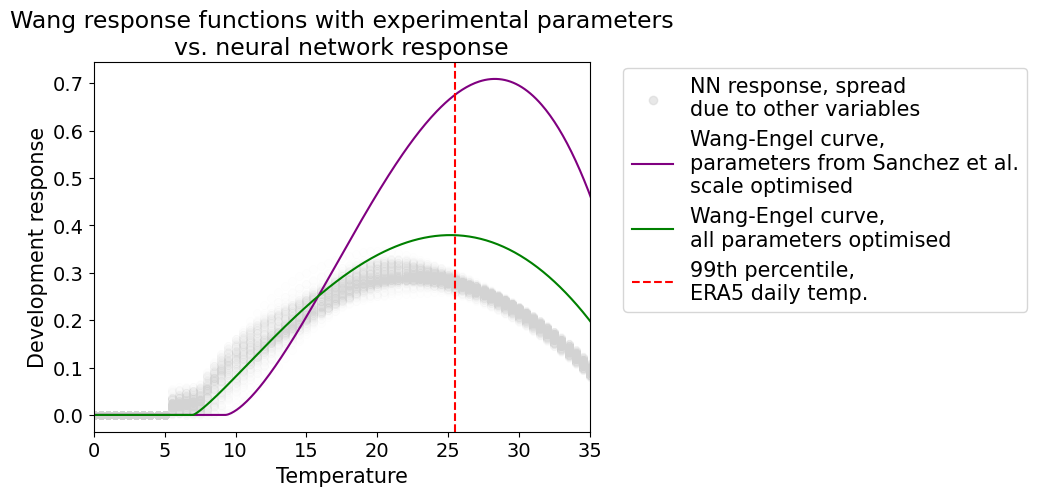

In [348]:
font_size = 15
fm_flowering_all_DE2 = [[[0.503004, 9.3, 28.3, 39.2]], 'ds_inputs_DE_reduced', 0]#[[[0.503004, 7.02058042, 27.00252239, 39.30655295]], 'ds_inputs_DE_reduced', 0]
x = fm_flowering_all_DE2[0][0]
x_0 = 0.708822
x_1 = 0.607894
#x_1 = 0.4
fm_flowering_all_DE = [[0.37934956, 7.0094127, 25.16467337, 39.17442218], 'ds_inputs_DE_reduced', 0]#[[ 0.37934956  7.0094127  25.16467337 39.17442218  2.5360532   4.80742285], 'ds_inputs_DE_reduced', 0]
table = vec_expint(x[1], x[2], x[3], np.arange(0, 50, 0.5), 8, 3)#, x[4], x[5])#x[2]
def response(meantemp):
    return x[0]*table[(np.round(meantemp/5, decimals = 1)*10).astype(int)]*(meantemp > 0)
xvals = np.arange(0, 50, 0.1)
fig, ax = plt.subplots()
input_tensor = temp_NDVI_series_DE
input_x = torch.ones((1, 8, 100))
for i, T in enumerate(np.arange(0, 50, 0.5)):
    input_x[0, 0, i] = T
vals_list = []
for experiment_index in range(100):
    sample_index = np.random.randint(0, input_tensor.shape[0])
    day_index = np.random.randint(0, temp_NDVI_series_DE.shape[2])
    input_x[0, 1, :] = input_tensor[sample_index, 1, day_index]
    input_x[0, 2, :] = input_tensor[sample_index, 2, day_index]
    input_x[0, 3, :] = input_tensor[sample_index, 3, day_index]
    input_x[0, 4, :] = input_tensor[sample_index, 4, day_index]
    input_x[0, 5, :] = input_tensor[sample_index, 5, day_index]
    with torch.no_grad():
        vals, x2 = forward_NN_KG2(model, input_x.transpose(1, 2))
    vals_list.append(vals.numpy().squeeze())
    if experiment_index == 0:
        ax.scatter(np.arange(0, 50, 0.5), vals.numpy().squeeze() + x2.squeeze().numpy(), color = 'lightgrey', alpha = 0.005)#, label='NN response, spread\ndue to other variables')
    else:
        ax.scatter(np.arange(0, 50, 0.5), vals.numpy().squeeze() + x2.squeeze().numpy(), color = 'lightgrey', alpha = 0.005)
ax.scatter([], [], color = 'lightgrey', alpha = 0.5, label='NN response, spread\ndue to other variables')
vals = np.mean(np.array(vals_list), axis=0)
vals_spread = np.std(np.array(vals_list), axis=0)
vals_LQ = np.quantile(np.array(vals_list), 0.1, axis=0)
vals_UQ = np.quantile(np.array(vals_list), 0.9, axis=0)
#ax.plot(np.arange(0, 50, 0.5), np.array(vals) + x2.squeeze().numpy() , color = 'black', label = 'mean response')
ax.plot(xvals, x_0*modelling_fctns.Wang_Engel_Temp_response(xvals, fm_flowering_all_DE2[0][0][1], fm_flowering_all_DE2[0][0][2], fm_flowering_all_DE2[0][0][3]), 
        label = 'Wang-Engel curve,\nparameters from Sanchez et al.\nscale optimised', color='Purple')#fm_flowering_all_DE2[0][0][0]
ax.plot(xvals, fm_flowering_all_DE[0][0]*modelling_fctns.Wang_Engel_Temp_response(xvals, fm_flowering_all_DE[0][1], fm_flowering_all_DE[0][2], fm_flowering_all_DE[0][3]), 
        label = 'Wang-Engel curve,\nall parameters optimised', color='Green')
#ax.fill_between(np.arange(0, 50, 0.5), vals_LQ + x2.squeeze().numpy(), vals_UQ+ x2.squeeze().numpy(), color = 'lightgrey', label = 'NN response, spread\ndue to other variables')

ax.axvline(np.quantile(ds_inputs_DE[[f't2m at day {n}' for n in range(150)]].values, 0.99), color = 'red', linestyle = '--', label = '99th percentile,\nERA5 daily temp.')
ax.set_xlim(0, 35)
ax.tick_params(axis='both', labelsize = font_size - 1)
ax.set_xlabel('Temperature', fontsize = font_size)
ax.set_ylabel('Development response', fontsize = font_size)
fig.legend(bbox_to_anchor=(1.6, 0.89), fontsize = font_size)
ax.set_title('Wang response functions with experimental parameters\nvs. neural network response', fontsize = font_size + 2)

In [181]:
np.array(vals_list).shape

(500, 100)

In [329]:
x2.squeeze()-vals

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_10872\3703562482.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x2.squeeze()-vals


tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,
         0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,
         0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,
         0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,
         0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,
         0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,
         0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,
         0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,
         0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031, -0.0031,
        -0.0031, -0.0031, -0.0031, -0.0031, -0.0031, -0.0031, -0.0031, -0.0031,
        -0.0031, -0.0031, -0.0031, -0.0031, -0.0031, -0.0031, -0.0031, -0.0031,
        -0.0031, -0.0031, -0.0031, -0.00

In [313]:
(model.fc.weight.data.squeeze()*model.layer8.bias.data).sum()

tensor(-0.0329)

In [ ]:
model.fc.weight.data.squeeze()

tensor([[ 8.8002e-04, -7.8018e-04, -6.1761e-05,  7.8139e-02,  2.2795e-02,
          2.7754e-02,  2.1979e-02,  8.1013e-02]])

In [279]:
np.mean(np.array(vals_list), axis=0)

array([-0.02297024, -0.02297024, -0.02297024, -0.02297024, -0.02297024,
       -0.02297024, -0.02297024, -0.02297024, -0.02297024, -0.02297024,
       -0.02297024, -0.02297024, -0.02297024, -0.02297024, -0.02297023,
       -0.02297023, -0.02297023, -0.02297023, -0.02297023, -0.02297023,
       -0.02297023, -0.02297023, -0.02297023, -0.02297023, -0.02297023,
       -0.02297022, -0.02297022, -0.02297022, -0.02297022, -0.02297022,
       -0.02297022, -0.02297022, -0.02297022, -0.02297022, -0.02297022,
       -0.02297022, -0.02297021, -0.02297021, -0.02297021, -0.02297021,
       -0.02297021, -0.02297021, -0.02297021, -0.02297021, -0.02297021,
       -0.02297021, -0.02297021, -0.02297021, -0.02297021, -0.02297021,
       -0.02297021, -0.02297021, -0.02297021, -0.02297021, -0.02297021,
       -0.02297021, -0.02297021, -0.02297021, -0.02297021, -0.02297021,
       -0.02297021, -0.0229702 , -0.0229702 , -0.0229702 , -0.0229702 ,
       -0.0229702 , -0.0229702 , -0.0229702 , -0.0229702 , -0.02

In [286]:
model.fc.bias#.data

Parameter containing:
tensor([-0.0230], requires_grad=True)

In [234]:
model.layer3.weight.data

tensor([[0.9478, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000]])

In [122]:
vals_LQ

array([0.0003113, 0.0003113, 0.0003113, 0.0003113, 0.0003113, 0.0003113,
       0.0003113, 0.0003113], dtype=float32)

In [106]:
np.quantile(np.array(vals_list), 0.9, axis=0)

array([-0.02532625, -0.02532625, -0.02532625, -0.02532625, -0.02532625,
       -0.02532625, -0.02532625, -0.02532625, -0.02532625, -0.02532625,
       -0.02532625, -0.02532625, -0.02532625, -0.02532625, -0.02532625,
       -0.02532625, -0.02532625, -0.02532625, -0.02532625, -0.02532625,
       -0.02532625, -0.02532625, -0.02532625, -0.02532625, -0.02532625,
       -0.02532625, -0.02532625, -0.02532625, -0.02532625, -0.02532625,
       -0.02532625, -0.02532625, -0.02532625, -0.02532625, -0.02532625,
       -0.02532625, -0.02532625, -0.02532625, -0.02532625, -0.02532625,
       -0.02532625, -0.02532625, -0.02532625, -0.02532625, -0.02532625,
       -0.02532625, -0.02532625, -0.02532625, -0.02532625, -0.02532625,
       -0.02532625, -0.02532625, -0.02532625, -0.02532625, -0.02532625,
       -0.02532625, -0.02532625, -0.02532625, -0.02532625, -0.02532625,
       -0.02532625, -0.02532625, -0.02532625, -0.02532625, -0.02532625,
       -0.02532625, -0.02532625, -0.02532625, -0.02532625, -0.02

Text(0.5, 1.0, 'Wang response functions with experimental parameters\nvs. neural network response')

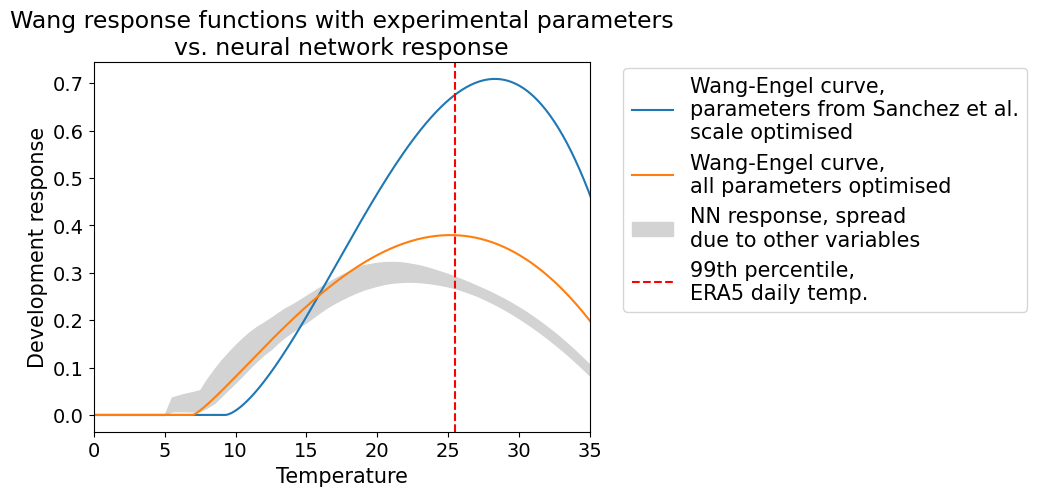

In [336]:
font_size = 15
fm_flowering_all_DE2 = [[[0.503004, 9.3, 28.3, 39.2]], 'ds_inputs_DE_reduced', 0]#[[[0.503004, 7.02058042, 27.00252239, 39.30655295]], 'ds_inputs_DE_reduced', 0]
x = fm_flowering_all_DE2[0][0]
x_0 = 0.708822
x_1 = 0.607894
#x_1 = 0.4
fm_flowering_all_DE = [[0.37934956, 7.0094127, 25.16467337, 39.17442218], 'ds_inputs_DE_reduced', 0]#[[ 0.37934956  7.0094127  25.16467337 39.17442218  2.5360532   4.80742285], 'ds_inputs_DE_reduced', 0]
table = vec_expint(x[1], x[2], x[3], np.arange(0, 50, 0.5), 8, 3)#, x[4], x[5])#x[2]
def response(meantemp):
    return x[0]*table[(np.round(meantemp/5, decimals = 1)*10).astype(int)]*(meantemp > 0)
xvals = np.arange(0, 50, 0.1)
fig, ax = plt.subplots()
ax.plot(xvals, x_0*modelling_fctns.Wang_Engel_Temp_response(xvals, fm_flowering_all_DE2[0][0][1], fm_flowering_all_DE2[0][0][2], fm_flowering_all_DE2[0][0][3]), label = 'Wang-Engel curve,\nparameters from Sanchez et al.\nscale optimised')#fm_flowering_all_DE2[0][0][0]
#ax.plot(np.arange(0, 50, 0.5), x_1*np.array(table), label = 'Convolved Wang-Engel curve,\nparameters from Sanchez et al.\nscale optimised')
ax.plot(xvals, fm_flowering_all_DE[0][0]*modelling_fctns.Wang_Engel_Temp_response(xvals, fm_flowering_all_DE[0][1], fm_flowering_all_DE[0][2], fm_flowering_all_DE[0][3]), label = 'Wang-Engel curve,\nall parameters optimised')
#ax.plot(np.arange(0, 50, 0.5), vals, label = 'Neural network response with\nother variables held constant')
#ax.fill_between(np.arange(0, 50, 0.5), vals - vals_spread , vals + vals_spread, color = 'lightgrey', label = 'NN response inc. spread\ndue to other variables')
ax.fill_between(np.arange(0, 50, 0.5), vals_LQ + x2.squeeze().numpy(), vals_UQ+ x2.squeeze().numpy(), color = 'lightgrey', label = 'NN response, spread\ndue to other variables')
#ax.set_title('Convolution SD in box of 7, temp range in day of 6')

ax.axvline(np.quantile(ds_inputs_DE[[f't2m at day {n}' for n in range(150)]].values, 0.99), color = 'red', linestyle = '--', label = '99th percentile,\nERA5 daily temp.')
#ax.axvline(np.quantile(ds_inputs_DE[[f't2m at day {n}' for n in range(150)]].values, 0.05), color = 'red', linestyle = '--', label = '1st percentile,\nERA5 daily temp.')
#ax.axvline(ds_inputs_DE[[f't2m at day {n}' for n in range(150)]].values.max(), color = 'red', linestyle = ':', label = '99th percentile,\nERA5 daily temp.')
#ax.axvline(ds_inputs_DE[[f't2m at day {n}' for n in range(150)]].values.min(), color = 'red', linestyle = ':', label = '1st percentile,\nERA5 daily temp.')
#ax.axvline(ds_inputs_DE['t2m at day 88'].mean(), color = 'red', linestyle = ':', label = 'Mean temp at mean day of flowering')
#ax.axvline(28.3, color = 'k', linestyle = '--', label = 'optimal temp from\nSanchez et al.')
#ax.axvline(fm_flowering_all_DE[0][2], color = 'k', label = 'optimal temp from optimisation')
ax.set_xlim(0, 35)
ax.tick_params(axis='both', labelsize = font_size - 1)
ax.set_xlabel('Temperature', fontsize = font_size)
ax.set_ylabel('Development response', fontsize = font_size)
fig.legend(bbox_to_anchor=(1.6, 0.89), fontsize = font_size)
ax.set_title('Wang response functions with experimental parameters\nvs. neural network response', fontsize = font_size + 2)


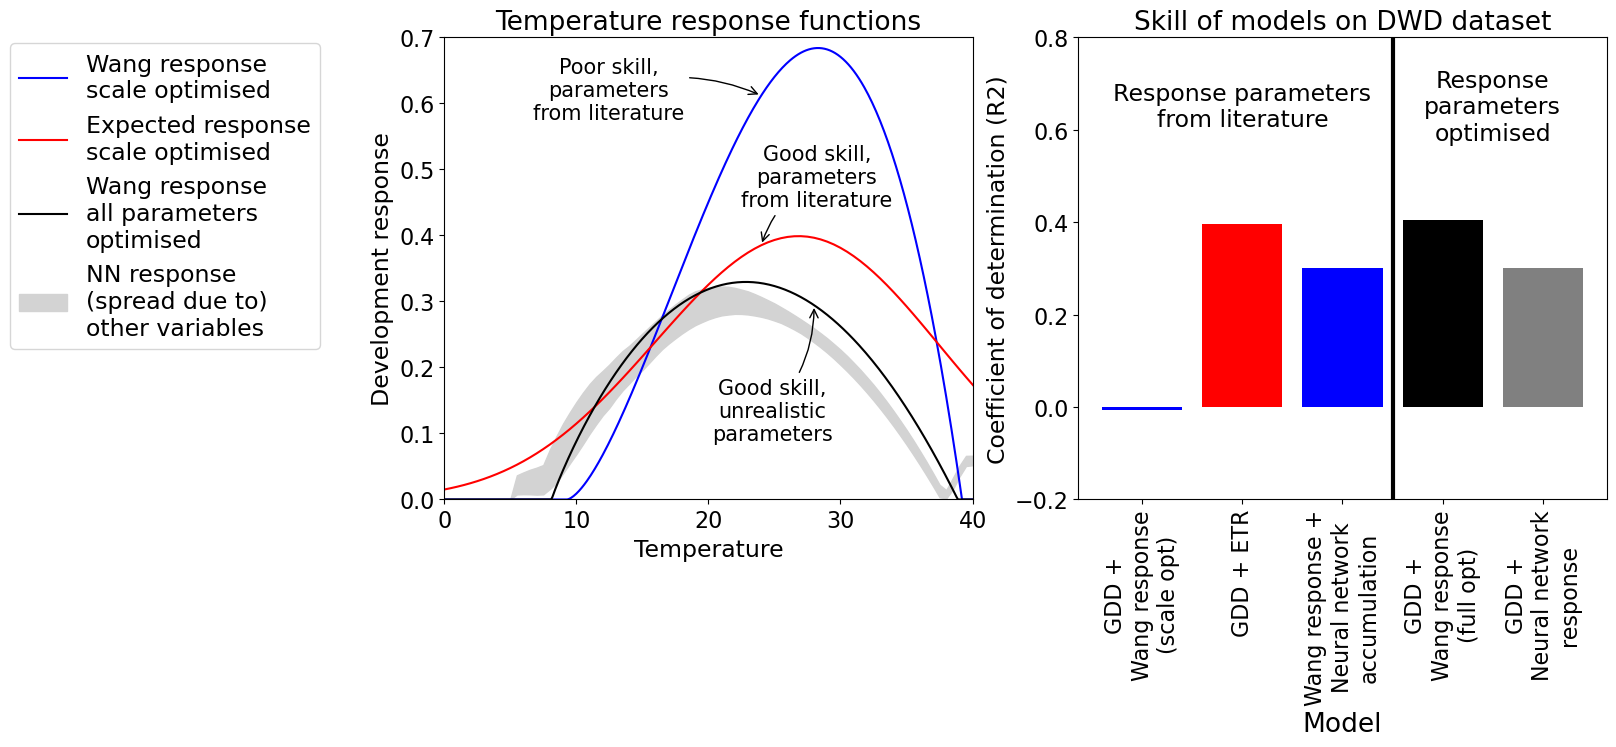

In [337]:
font_size = 17
x_1 = 0.684018
x_3 = 0.329584
x_0_conv =  0.587931
table = vec_expint(9.3, 28.3, 39.2, np.arange(0, 50, 0.5), 8, 3)#, x[4], x[5])#x[2]
fm_flowering_all_DE2 = [[[x_1, 9.3, 28.3, 39.2]], 'ds_inputs_DE_reduced', 0]#[[[0.503004, 7.02058042, 27.00252239, 39.30655295]], 'ds_inputs_DE_reduced', 0]
fm_flowering_all_DE = [[[x_3, 8.13380267, 22.83931163, 38.88095627], ds_inputs_DE, 0]]#[[[0.34525542, 7.00219008, 23.57229066, 39.02041395]], ds_inputs_DE, 0]
x = fm_flowering_all_DE2[0][0]
xvals = np.arange(0, 50, 0.1)
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
ax = axs[0]
ax.plot(xvals, x[0]*modelling_fctns.Wang_Engel_Temp_response(xvals, x[1], x[2], x[3]), label = 'Wang response\nscale optimised', color = 'blue')#linestyle = '-.', color = 'k'fm_flowering_all_DE2[0][0][0] \nSanchez parameters,
ax.plot(np.arange(0, 50, 0.5), x_0_conv*table, label = 'Expected response\nscale optimised', color = 'red')#\nSanchez parameters
ax.plot(xvals, fm_flowering_all_DE[0][0][0]*modelling_fctns.Wang_Engel_Temp_response(xvals, fm_flowering_all_DE[0][0][1], fm_flowering_all_DE[0][0][2], fm_flowering_all_DE[0][0][3]), 
        label = 'Wang response\nall parameters\noptimised', color='k')
ax.fill_between(np.arange(0, 50, 0.5), vals_LQ + x2.squeeze().numpy(), vals_UQ + x2.squeeze().numpy(), color = 'lightgrey', label = 'NN response\n(spread due to)\nother variables')
#ax.set_title('Convolution SD in box of 7, temp range in day of 6')
percentile_99 = np.quantile(ds_inputs_DE[[f't2m at day {n}' for n in range(150)]].values, 0.99)
percentile_1 = np.quantile(ds_inputs_DE[[f't2m at day {n}' for n in range(150)]].values, 0.01)
#ax.axvline(np.quantile(ds_inputs_DE[[f't2m at day {n}' for n in range(150)]].values, 0.99), color = 'k', linestyle = ':', label = '99th percentile,\nERA5 daily temp.')
#ax.axvline(np.quantile(ds_inputs_DE[[f't2m at day {n}' for n in range(150)]].values, 0.01), color = 'k', linestyle = '--', label = '1st percentile,\nERA5 daily temp.')
#ax.fill_betweenx([0, 0.7], [0, 0], [percentile_1, percentile_1], color = 'gray', alpha = 0.2, label = 'Temp. below/above\n1st/99th percentile\nof ERA5 data')
#ax.fill_betweenx([0, 0.7], [percentile_99, percentile_99], [50, 50], color = 'gray', alpha = 0.2)
#ax.axvline(ds_inputs_DE['t2m at day 88'].mean(), color = 'red', linestyle = ':', label = 'Mean temp at mean day of flowering')
#ax.axvline(28.3, color = 'k', linestyle = '--', label = 'optimal temp from\nSanchez et al.')
#ax.axvline(fm_flowering_all_DE[0][0][2], color = 'k', label = 'optimal temp from optimisation')
ax.set_xlim(0, 40)
ax.set_ylim(0, 0.7)
ax.tick_params(axis='both', labelsize = font_size - 1)
ax.set_xlabel('Temperature', fontsize = font_size)
ax.set_ylabel('Development response', fontsize = font_size)
fig.legend(bbox_to_anchor=(0.05, 0.89), fontsize = font_size)
ax.set_title('Temperature response functions', fontsize = font_size + 2)
conv_ylabel = x_0_conv*table[48]
conv_xlabel = np.arange(0, 50, 0.5)[48]
ax.annotate('Good skill,\nparameters\nfrom literature',
            xy=(conv_xlabel, conv_ylabel), xycoords='data',
            xytext=(40, 25), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3,rad=0.2"),
            horizontalalignment='center', verticalalignment='bottom',
            fontsize = font_size-2)
wang_ylabel = fm_flowering_all_DE[0][0][0]*modelling_fctns.Wang_Engel_Temp_response(28, fm_flowering_all_DE[0][0][1], fm_flowering_all_DE[0][0][2], fm_flowering_all_DE[0][0][3])
wang_xlabel = 28
ax.annotate('Good skill,\nunrealistic\nparameters',
            xy=(wang_xlabel, wang_ylabel), xycoords='data',
            xytext=(-30, -100), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3,rad=.2"),
            horizontalalignment='center', verticalalignment='bottom',
            fontsize = font_size-2)
sanchez_ylabel = x[0]*modelling_fctns.Wang_Engel_Temp_response(24, x[1], x[2], x[3])
sanchez_xlabel = 24
ax.annotate('Poor skill,\nparameters\nfrom literature',
            xy=(sanchez_xlabel, sanchez_ylabel), xycoords='data',
            xytext=(-110, -20), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3,rad=-.2"),
            horizontalalignment='center', verticalalignment='bottom',
            fontsize = font_size-2)
NN_ylabel = vals_UQ[24]
NN_xlabel = 12
ax.annotate('Neural network -\nwhole structure\nfrom data',
            xy=(NN_xlabel, NN_ylabel), xycoords='data',
            xytext=(-40, 30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3,rad=-.2"),
            horizontalalignment='center', verticalalignment='bottom',
            fontsize = font_size-2)
model_list = ['GDD +\nWang response\n(scale opt)', 'GDD + ETR', 'Wang response +\nNeural network\naccumulation', 'GDD +\nWang response\n(full opt)',  'GDD +\nNeural network\nresponse']
err_df = pd.DataFrame({
    'model': model_list,
    'R2': [-0.007274488791904732, 0.3971851248423798, 0.3, 0.404027147557559, 0.30066704750061035]})
ax = axs[1]
ax.bar(data=err_df, x='model', height='R2', color = ['blue', 'red', 'blue', 'k', 'gray'])
ax.tick_params(axis='both', labelsize = font_size - 1)
ax.tick_params(axis='x', rotation = 90)
ax.set_xlabel('Model', fontsize = font_size + 2)
ax.set_ylabel('Coefficient of determination (R2)', fontsize = font_size)
ax.axvline(2.5, color='k', linewidth = 3)
ax.set_ylim((-0.2, 0.8))
ax.annotate('Response parameters\nfrom literature',
            xy=(1, 0.65), xycoords='data',
            xytext=(0, 0), textcoords='offset pixels',
            horizontalalignment='center',
            verticalalignment='center', fontsize = font_size)
ax.annotate('Response\nparameters\noptimised',
            xy=(3.5, 0.65), xycoords='data',
            xytext=(0, 0), textcoords='offset pixels',
            horizontalalignment='center',
            verticalalignment='center', fontsize = font_size)
ax.set_title('Skill of models on DWD dataset', fontsize = font_size + 2)
fig.savefig('C:\\Users\\wlwc1989\\Documents\\paper 1\\iCropM plots\\iCropM_plot.png', bbox_inches='tight')

In [129]:
np.quantile(ds_inputs_DE[[f't2m at day {n}' for n in range(120)]].values, 0.01)

np.float64(6.6684328604979655)

<BarContainer object of 5 artists>

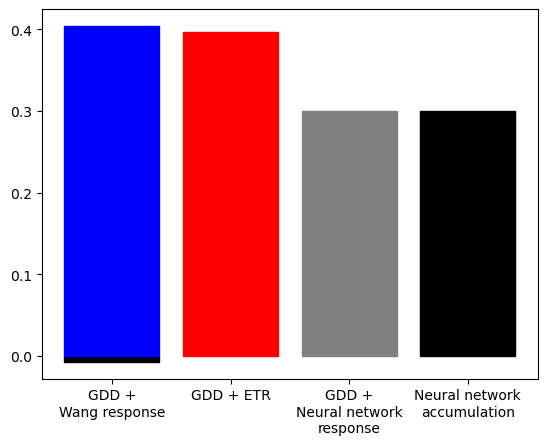

In [92]:
fig, ax = plt.subplots()
ax.bar(data=err_df, x='model', height='R2', color = ['k', 'red', 'blue', 'gray', 'k'], edgecolor = ['k', 'red', 'blue', 'gray', 'k'])

In [87]:
err_df

,model,R2
0,GDD +\nWang response,-0.007274
1,GDD + ETR,0.397185
2,GDD +\nWang response,0.404027
3,GDD +\nNeural network\nresponse,0.300667
4,Neural network\naccumulation,0.300000


In [15]:
#train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.01)
comparison_frame = get_comparison_frame(save_name, model, val_dl, bce=True, CNN=False, MMD=False, DTF = False, n_channels = n_channels, obs_method = False)

TypeError: get_comparison_frame() got an unexpected keyword argument 'MMD'

In [81]:
def plot_from_saved(savename, model, val_dl, method = 'regression', bce=False, CNN=False, title = 'fitted vs. observed', MMD=False):
    model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
    model_path = os.path.join(model_dir, savename + ".pt")
    checkpoint = torch.load(model_path, weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    #print(model.u4)
    #model.u4=nn.Parameter(torch.Tensor([0.02]))
    #print(model.u4)
    #print(checkpoint['model_state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if method == 'cumulative':
        plot_fitted_observed_cumulative(model, val_dl, bce=bce, CNN=CNN, title=title, MMD=MMD)
    elif method == 'regression':
        plot_fitted_observed_TS(model, val_dl, bce=bce, CNN=CNN, title=title, MMD=MMD)
    elif method == 'histogram':
        plot_fitted_observed_histogram(model, val_dl, bce=bce, CNN=CNN, title=title, MMD=MMD)

In [76]:
for xb, yb in val_dl_SSA:
    print(yb.shape)

torch.Size([252, 163])


torch.Size([252, 163]) torch.Size([252, 163, 1])
R^2 value for model: 0.28196239471435547
Bias: 0.5565648078918457
Variance of modelled values: 22.250215530395508


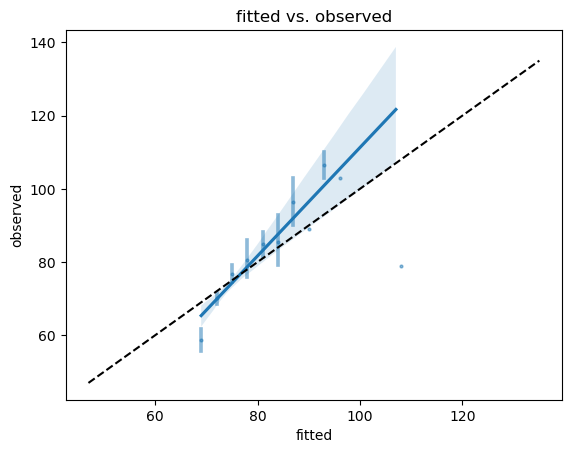

In [98]:
train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.01)
plot_from_saved('KFold4', model, val_dl_SSA, method = 'regression', bce=True, CNN=False)#

In [29]:
R2s = []
Biases = []
Variances = []

RMSEs = []
STDs = []
Corrs = []

Mins = []
LQs = []
Medians = []
UQs = []
Maxs = []

comparison_frame['Error'] = comparison_frame['observed'] - comparison_frame['fitted']

r2_score_model = r2_score(comparison_frame['observed'], comparison_frame['fitted'])
bias_model = (comparison_frame['Error']).mean()
variance = comparison_frame['fitted'].var()

RMSE = np.sqrt(np.mean((comparison_frame['Error'] - bias_model)**2))
STD = comparison_frame['fitted'].std() 
Corr = comparison_frame['observed'].corr(comparison_frame['fitted'])

RMSEs.append(RMSE)
STDs.append(STD)
Corrs.append(Corr)

Mins.append(comparison_frame['Error'].min())
LQs.append(comparison_frame['Error'].quantile(0.25))
Medians.append(comparison_frame['Error'].median())
UQs.append(comparison_frame['Error'].quantile(0.75))
Maxs.append(comparison_frame['Error'].max())

R2s.append(r2_score_model)
Biases.append(bias_model)
Variances.append(variance)

0 0.09037242921541684 0.10456027343441239
5 0.08992410350411305 0.1032807466722344
10 0.08961512309671998 0.102224383765817
15 0.08925422871609769 0.10115735964270858
20 0.0889349236885529 0.10146962047868235
25 0.08862703296483329 0.09941004666040211


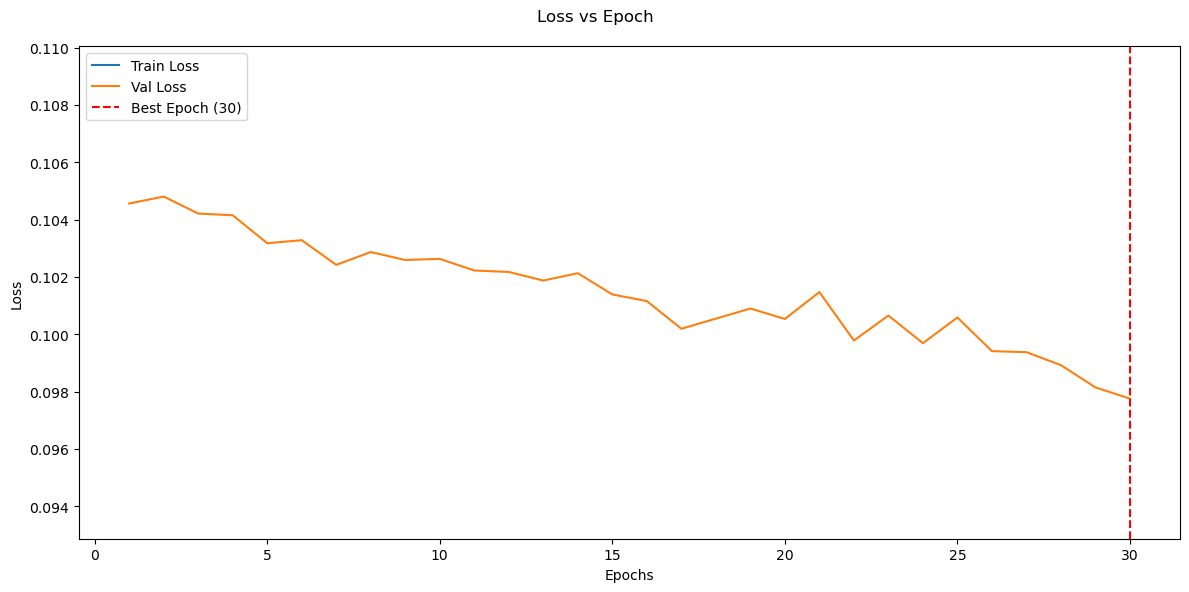

In [18]:
epochs = 30
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = False, bce=True)

OrderedDict([('u0', tensor([1.3818])), ('u1', tensor([0.])), ('u2', tensor([0.])), ('u3', tensor([0.])), ('u4', tensor([0.7990])), ('p0', tensor([13.])), ('lstm.weight_ih_l0', tensor([[-0.2404, -0.1111, -0.0454,  0.1936, -0.1655,  0.2254],
        [ 0.0169,  0.1593, -0.2032, -0.1482, -0.2339,  0.1009],
        [ 0.2236,  0.1397, -0.2136,  0.0487, -0.0030,  0.2439],
        [ 0.0247, -0.0894,  0.0249,  0.1936, -0.1072,  0.1596],
        [ 0.2204,  0.2266,  0.1290, -0.0725, -0.1771,  0.1854],
        [-0.1598, -0.1249, -0.1199,  0.1603,  0.1980, -0.0941],
        [ 0.0595, -0.1074, -0.1272,  0.0507,  0.1801,  0.0470],
        [ 0.1084, -0.0007,  0.0567, -0.1048, -0.0686,  0.0260],
        [-0.1499,  0.2432, -0.0648,  0.0694, -0.1028, -0.2424],
        [ 0.2043,  0.0965, -0.2228, -0.1323,  0.1925,  0.0979],
        [ 0.2374, -0.0669, -0.0016, -0.0945, -0.1193, -0.2051],
        [-0.1734,  0.1449, -0.1191,  0.1223, -0.1977,  0.0706],
        [-0.1951, -0.0595, -0.2058, -0.0386, -0.0839, -0

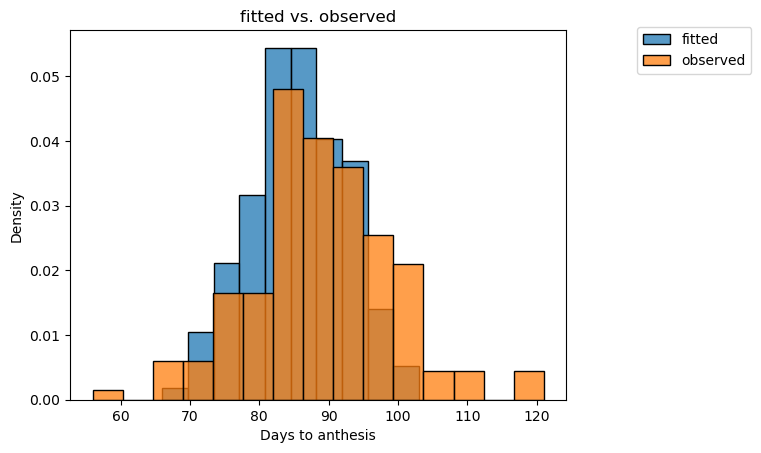

In [17]:
plot_from_saved(save_name, model, val_dl, method = 'histogram', bce=True, CNN=False)#

In [46]:
for x, y in train_dl:
    print(len(x))

500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
299


In [51]:
input_dim = 4
savename = 'NN_response_SSA' #'LSTM_KG_SAT_pp'save_name = 'CCNN_SAT_pp_KG'
model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
model_path = os.path.join(model_dir, savename + ".pt")
checkpoint = torch.load(model_path, weights_only=True)
model = nn_temp_response(input_dim, hidden_dim, num_layers, output_dim, KG =True) #LSTMClassifier_KG(input_dim, hidden_dim, num_layers, output_dim)
model.load_state_dict(checkpoint['model_state_dict'])
for param in model.parameters():
    param.requires_grad = False
for param in [model.u0, model.u1, model.u2, model.u3, model.u4, model.p0]:
    param.requires_grad = True

RuntimeError: Error(s) in loading state_dict for nn_temp_response:
	Missing key(s) in state_dict: "u4". 

0 0.3747577965259552 53.4495735168457
5 53.58411407470703 53.4495735168457
10 53.58411407470703 53.4495735168457
15 53.58411407470703 53.4495735168457
20 53.58411407470703 53.4495735168457
25 53.58411407470703 53.4495735168457
30 53.58411407470703 53.4495735168457
35 53.58411407470703 53.4495735168457
40 53.58411407470703 53.4495735168457
45 53.58411407470703 53.4495735168457
50 53.58411407470703 53.4495735168457
55 53.58411407470703 53.4495735168457
60 53.58411407470703 53.4495735168457
65 53.58411407470703 53.4495735168457
70 53.58411407470703 53.4495735168457
75 53.58411407470703 53.4495735168457
80 53.58411407470703 53.4495735168457
85 53.58411407470703 53.4495735168457
90 53.58411407470703 53.4495735168457
95 53.58411407470703 53.4495735168457
100 53.58411407470703 53.4495735168457
105 53.58411407470703 53.4495735168457
110 53.58411407470703 53.4495735168457
115 53.58411407470703 53.4495735168457
120 53.58411407470703 53.4495735168457
125 53.58411407470703 53.4495735168457
130 53.

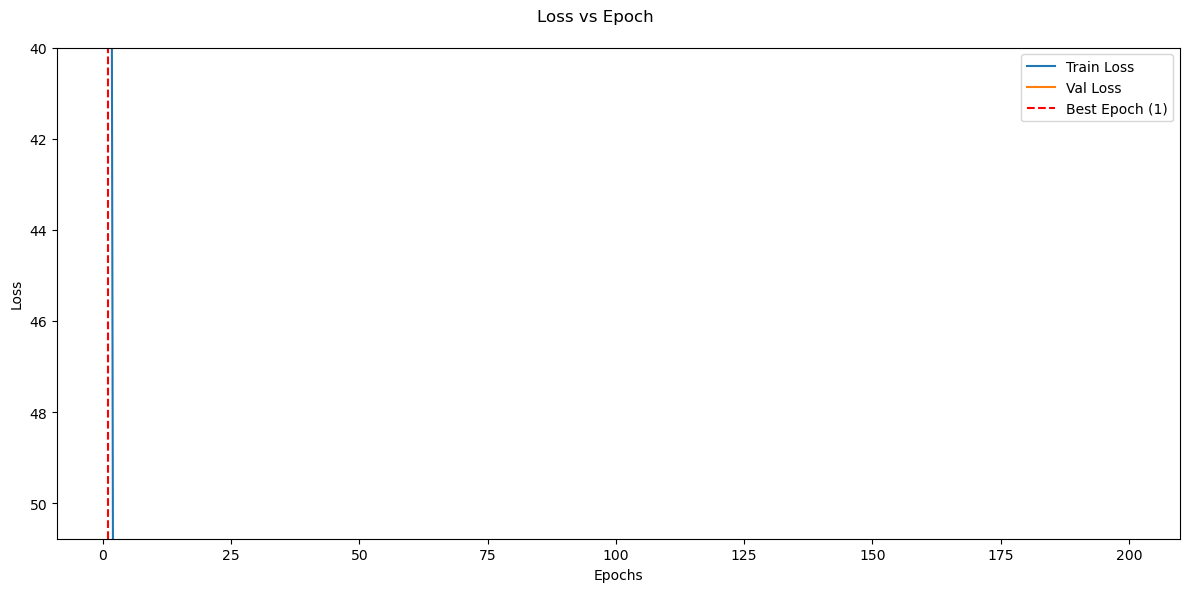

In [52]:
bs = 500
n_channels = 4
train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.5)
save_name = 'nn_KG_SSA_TL'
# Loss function and optimizer
criterion = criterion = nn.BCELoss()#nn.NLLLoss()  # For multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

epochs = 200
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN=False, bce = True)

In [49]:
k_folds=5
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
model_class = nn_temp_response
savename =  'NN_response_DE'
epochs = 200
bs = 500
input_dim = 4
hidden_dim = 16
num_layers = 4
output_dim = 1
KG = True
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG)
loss_values, R2s, Biases, Variances = K_fold_transfer(k_folds, train_ds, model_class, savename, epochs, bs, model_args, lr = 0.01, savename_prefix = 'KFold', freeze_params = False, loss = 'BCE', CNN=False, bce=True)

Fold 1
Loss: 0.11896631866693497
Fold 2
Loss: 0.11890595406293869
Fold 3
Loss: 0.11161382496356964
Fold 4
Loss: 0.11943992227315903
Fold 5
Loss: 0.10649867355823517


In [92]:
k_folds=5
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
model_class = nn_temp_response
save_name= 'NN_response_DE_no_day'
epochs = 200
bs = 500
input_dim = 5
hidden_dim = 16
num_layers = 4
output_dim = 1
KG = False
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG)
loss_values, R2s, Biases, Variances = K_fold_transfer(k_folds, train_ds, model_class, save_name, epochs, bs, model_args, lr = 0.01, savename_prefix = 'KFold', freeze_params = False, loss = 'BCE', CNN=False, bce=True)

Fold 1
Loss: 0.12871979176998138
Fold 2
Loss: 0.10623729974031448
Fold 3
Loss: 0.13243165612220764
Fold 4
Loss: 0.13086050748825073
Fold 5
Loss: 0.12835103273391724


In [93]:
R2s

[0.3179613947868347,
 0.22253692150115967,
 0.3240765929222107,
 0.16850709915161133,
 0.3345268964767456]

In [ ]:
k_folds=5
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
model_class = nn_temp_response
savename =  'NN_response_DE'
epochs = 200
bs = 500
input_dim = 4
hidden_dim = 16
num_layers = 4
output_dim = 1
KG = True
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG)
loss_values, R2s, Biases, Variances = K_fold_transfer(k_folds, train_ds, model_class, savename, epochs, bs, model_args, lr = 0.01, savename_prefix = 'KFold', freeze_params = False, loss = 'BCE', CNN=False, bce=True)

In [50]:
np.mean(R2s)

0.3838975191116333

OrderedDict([('u0', tensor([3.0300])), ('u1', tensor([0.4097])), ('u2', tensor([0.0449])), ('u3', tensor([-0.5913])), ('p0', tensor([13.])), ('lstm.weight_ih_l0', tensor([[ 0.1043, -0.1732, -0.0477,  0.1512],
        [-0.0545,  0.0497, -0.2428,  0.0014],
        [ 0.1945,  0.0507, -0.1964,  0.0299],
        [-0.2144, -0.1459, -0.0323, -0.0244],
        [-0.2213, -0.2290, -0.0947,  0.2399],
        [ 0.0758,  0.1267,  0.0760,  0.0709],
        [ 0.0857,  0.0354,  0.0365, -0.1485],
        [-0.1117, -0.0730,  0.0718, -0.1403],
        [-0.0883,  0.1695,  0.1737,  0.0485],
        [ 0.1216,  0.1737, -0.1048,  0.0343],
        [ 0.0709, -0.0815, -0.0661, -0.0558],
        [ 0.1102, -0.0238,  0.1316,  0.1946],
        [-0.0562,  0.0013, -0.1097,  0.2364],
        [-0.1537,  0.1375,  0.1374, -0.1491],
        [-0.0216,  0.2121,  0.0229, -0.1307],
        [ 0.2094,  0.1508,  0.1870,  0.1204],
        [-0.0817, -0.0098,  0.1564,  0.1775],
        [-0.2445,  0.2046, -0.1549, -0.0738],
        [

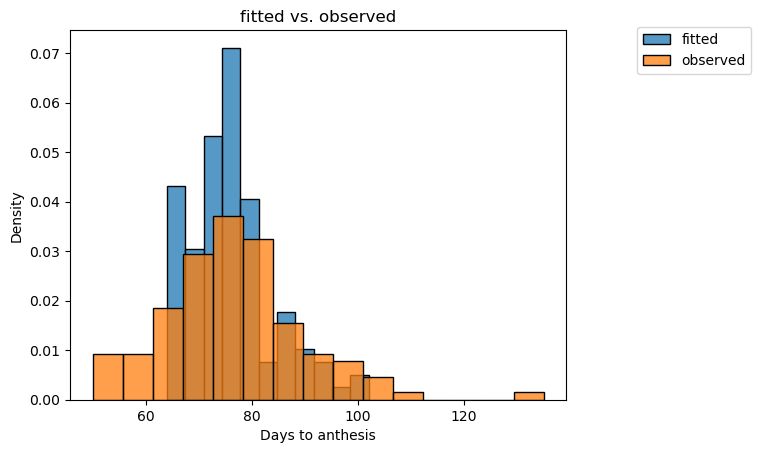

In [31]:
train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.1)
train_dl_DE, val_dl_DE = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels, train_proportion=0.1)
plot_from_saved(save_name, model, val_dl, method = 'histogram', bce=True, CNN=False)#

OrderedDict([('u0', tensor([1.1530])), ('u1', tensor([-0.1794])), ('u2', tensor([0.3816])), ('u3', tensor([-0.4020])), ('p0', tensor([13.])), ('lstm.weight_ih_l0', tensor([[-0.1974, -0.2006, -0.0475,  0.2221],
        [ 0.0257, -0.0198, -0.0496,  0.0122],
        [ 0.1149, -0.2155,  0.1518,  0.1868],
        [-0.1645, -0.1128,  0.0752,  0.1435],
        [-0.2248,  0.2379, -0.0086, -0.0520],
        [-0.1826, -0.0774,  0.1675,  0.1776],
        [ 0.2482,  0.2398,  0.1657, -0.0479],
        [ 0.1480, -0.2085,  0.2146,  0.1298],
        [-0.0570, -0.1773, -0.0914,  0.0834],
        [-0.1016, -0.1098,  0.2369,  0.0051],
        [ 0.0644,  0.1220,  0.2233,  0.2405],
        [ 0.2089, -0.1299,  0.0426,  0.0930],
        [-0.0095,  0.0818, -0.1380,  0.2496],
        [-0.0396, -0.1339,  0.2145, -0.1666],
        [ 0.1908,  0.1698,  0.0816, -0.1312],
        [ 0.2103, -0.0689,  0.0935, -0.1742],
        [-0.0281,  0.1960, -0.1748,  0.0414],
        [-0.1968, -0.1785, -0.1091,  0.2427],
        

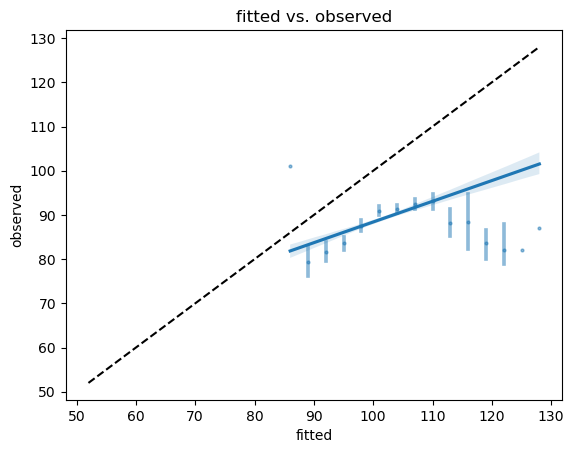

In [41]:
#save_name= 'Simple_NN_KG_SAT_pp'
train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.1)
train_dl_DE, val_dl_DE = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels, train_proportion=0.1)
plot_from_saved(save_name, model, val_dl_DE, method = 'regression', bce=bce, CNN=CNN)#

In [15]:
bs = 500
n_channels = 4

input_dim = n_channels # Example: 100-dimensional word embeddings
output_dim = 1  # Example: 5 classes

epochs = 100
model_class = nn_temp_response
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, train_proportion=1)

CNN = False
bce = True

k_folds = 5

for num_layers in [4, 8, 16]:
    for hidden_dim in [4, 8, 16]:
        print(num_layers, 'layers', ' hidden dim', hidden_dim)
        if num_layers == 4 and hidden_dim == 4:
            continue
        CNN_args = (input_dim, hidden_dim, num_layers, output_dim)
        loss_values, R2s, Biases, Variances = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, CNN_args, savename_prefix = 'KFold', loss = 'BCE', CNN=CNN, bce=bce)
        score = np.mean(loss_values)
        score_std = np.std(loss_values)
        R2_score = np.mean(R2s)
        R2_std = np.std(R2s)
        print(f'{num_layers} layers\nhidden dim {hidden_dim}\nloss {score} +/- {score_std}\nR2 {R2_score} +/- {R2_std}')

4 layers  hidden dim 4
4 layers  hidden dim 8
Fold 1
Loss: 0.09616621111788647
Fold 2
Loss: 0.09566244860446822
Fold 3
Loss: 0.09476258567863469
Fold 4
Loss: 0.09438741723520498
Fold 5
Loss: 0.09320732081260687
4 layers
hidden dim 8
loss 0.09493828170281887 +/- 0.002420975512318771
R2 0.37770284414291383 +/- 0.019117042911555693
4 layers  hidden dim 16
Fold 1
Loss: 0.09261867260383762
Fold 2
Loss: 0.09239977217391353
Fold 3
Loss: 0.09415661846640051
Fold 4
Loss: 0.09497429841538102
Fold 5
Loss: 0.09179341441275127
4 layers
hidden dim 16
loss 0.09486407761935563 +/- 0.004295512494431185
R2 0.3825199007987976 +/- 0.03583584992555995
8 layers  hidden dim 4
Fold 1
Loss: 0.0961160135534185
Fold 2
Loss: 0.10060566749309494
Fold 3
Loss: 0.09688205700984269
Fold 4
Loss: 0.09487669004143157
Fold 5
Loss: 0.09302868716818326
8 layers
hidden dim 4
loss 0.09687764126985862 +/- 0.003657330615980168
R2 0.3614853620529175 +/- 0.026865292197698572
8 layers  hidden dim 8
Fold 1
Loss: 0.09523385585723479

KeyboardInterrupt: 

4 layers
hidden dim 8
loss 0.09493828170281887 +/- 0.002420975512318771
R2 0.37770284414291383 +/- 0.019117042911555693

4 layers
hidden dim 16
loss 0.09486407761935563 +/- 0.004295512494431185
R2 0.3825199007987976 +/- 0.03583584992555995

8 layers
hidden dim 4
loss 0.09687764126985862 +/- 0.003657330615980168
R2 0.3614853620529175 +/- 0.026865292197698572

8 layers
hidden dim 8
loss 0.09825641053378115 +/- 0.0018010093072599591
R2 0.34743714332580566 +/- 0.039617697187614036

8 layers
hidden dim 16
loss 0.09622502034269967 +/- 0.0037492410465446847
R2 0.3490405440330505 +/- 0.0566075686691473

4 layers
hidden dim 4
loss 0.09671930811207077 +/- 0.0018048219953200194
R2 0.3694689631462097 +/- 0.017327979076895317

In [42]:
comparison_frame = get_comparison_frame(save_name, model, val_dl_DE, bce=bce, CNN=CNN)

In [43]:
comparison_frame['fitted'] = comparison_frame['fitted'] - comparison_frame['fitted'].mean()
comparison_frame['observed'] = comparison_frame['observed'] - comparison_frame['observed'].mean()

In [44]:
r2_score(comparison_frame['observed'] - comparison_frame['observed'].mean(), comparison_frame['fitted'] - comparison_frame['fitted'].mean()) #

-0.016082406044006348

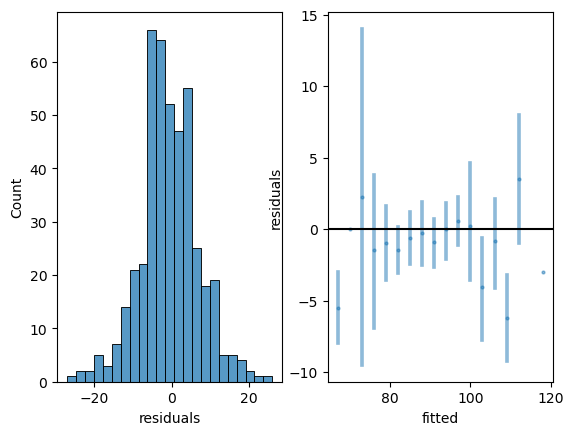

In [44]:
plot_residuals(comparison_frame)

In [43]:
def plot_residuals(comparison_frame):
    fig, axs = plt.subplots(1, 2)
    comparison_frame['residuals'] = comparison_frame['observed'] - comparison_frame['fitted']
    sns.histplot(comparison_frame['residuals'], ax = axs[0])
    maxval = max(comparison_frame['fitted'].max(), comparison_frame['residuals'].max())
    minval = min(comparison_frame['fitted'].min(), comparison_frame['residuals'].min())
    
    sns.regplot(x='fitted', y='residuals', data = comparison_frame, ax=axs[1],
                scatter_kws={'alpha':0.5, 's':4},  x_bins=np.arange(minval - 5, maxval + 5, 3),
                fit_reg = False)
    axs[1].axhline(0, color = 'black')

In [18]:
class simple_nn_Classifier_KG(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(simple_nn_Classifier_KG, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=False) # batch_first handles input shape (batch, seq, features)
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.layer1 = nn.Linear(hidden_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.layer4= nn.Linear(hidden_dim, hidden_dim)
        self.layer5 = nn.Linear(hidden_dim, hidden_dim)
        self.layer6= nn.Linear(hidden_dim, hidden_dim)
        self.layer7 = nn.Linear(hidden_dim, hidden_dim)
        self.layer8 = nn.Linear(hidden_dim, hidden_dim)
        self.layer9 = nn.Linear(hidden_dim, hidden_dim)
        self.layer10= nn.Linear(hidden_dim, hidden_dim)
        self.layer11 = nn.Linear(hidden_dim, hidden_dim)
        self.layer12 = nn.Linear(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)  # Fully connected layer for classification
        self.input_dim = input_dim
        self.sig = nn.Sigmoid()

        self.activation = nn.LeakyReLU(negative_slope=0.01)

        self.u0 = torch.nn.Parameter(torch.Tensor([1]))
        self.u1 = torch.nn.Parameter(torch.Tensor([0]))
        self.u2 = torch.nn.Parameter(torch.Tensor([0]))
        self.u3 = torch.nn.Parameter(torch.Tensor([0]))

        self.p0 = torch.nn.Parameter(torch.Tensor([13]))
        

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device) # Initialize hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device) # Initialize cell state
        # Apply Wang Engel
        T_min = 9 + 2*(torch.tanh(self.u1))
        T_opt = 28 + 3*(torch.tanh(self.u2))
        T_max = 39 + torch.tanh(self.u3)
        alpha = np.log(2)/torch.log( (T_max - T_min)/(T_opt - T_min) )
        beta = 1
        #print(T_min, T_opt, T_max)
        #print(alpha)
        #print(((2*(x - T_min)*(x >= T_min))**alpha))
        #x[:, :, 0] = ( ( ((2*(x[:, :, 0] - T_min)*(x[:, :, 0] >= T_min))**alpha)*((T_opt - T_min)**alpha) - (((x[:, :, 0] - T_min)*(x[:, :, 0] >= T_min))**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta
        #x = torch.nan_to_num(x)
        #x = x*(x >= T_min)*(x<= T_max)
        #print(x)
        #print(x, x.shape)
        # Make cumulative
        x[:, :, 0] = self.u0*torch.cumsum(x[:, :, 0], dim = 1)
        if self.input_dim == 3:
            x[:, :, 1] = 0.5*(1 + torch.tanh(2*(x[:, :, 1] - self.p0)))
        # Forward pass through LSTM
        #x = torch.swapaxes(x, 1, 2)
        for i, linlayer in enumerate([self.input_layer, self.layer1, self.layer2, self.layer3, 
                                      self.layer4, self.layer5, self.layer6,
                                      self.layer7, self.layer8, self.layer9,
                                      self.layer10, self.layer11, self.layer12]):
            #print(i)
            #print(x.shape)
            #print(conv)
            x = linlayer(x)
            x = self.activation(x)
            #x = x[:, :, :-conv.padding[0]]
        #torch.nn.init.xavier_uniform(self.fc.weight)
        # Get the hidden state of the last time step
        # output[:, -1, :] is more efficient for batch_first=True
        #last_hidden = output[:, -1, :] # (batch, hidden_dim)
        #print(self.fc(output))
        
        # Classify all layers using fully connected layer
        out_space = self.fc(x) # (batch, output_dim)
        if self.output_dim == 1:
            out_scores = self.sig(out_space)
        else:
            out_scores = F.log_softmax(out_space, dim=2)


        return out_scores

In [ ]:
bs = 250
n_channels = 3

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8
num_layers = 2
output_dim = 2  # Example: 5 classes

epochs = 50
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, train_proportion=1)
k_folds = 5
model_args = (input_dim, hidden_dim, num_layers, output_dim)

model_class = simple_nn_Classifier_KG

loss_values_raw, R2s_raw, Biases_raw, Variances_raw = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, model_args, savename_prefix = 'KFold', freeze_params=True, loss='NLL', bce=False, CNN=False)

Fold 1
Loss: 0.08391246811878504
Fold 2
Loss: 0.08361983797087426
Fold 3
Loss: 0.08282656307082939
Fold 4
Loss: 0.0840181593704131
Fold 5
Loss: 0.08372888977491157


In [ ]:
score = np.mean(loss_values_raw)
score_stde = np.std(loss_values_raw)/np.sqrt(5)
R2_score = np.mean(R2s_raw)
R2_stde = np.std(R2s_raw)/np.sqrt(5)
print(f'#### simple nn model SSA ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}')

#### simple nn model SSA ####
loss 0.09319833964109421 +/- 0.008512759681746064
R2 0.3604199528694153 +/- 0.07515899247537987


In [ ]:
score = np.mean(loss_values_raw)
score_stde = np.std(loss_values_raw)/np.sqrt(5)
R2_score = np.mean(R2s_raw)
R2_stde = np.std(R2s_raw)/np.sqrt(5)
Bias = np.mean(Biases_raw)
Variance = np.mean(Variances_raw)
print(f'#### simple nn model ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}')

#### simple nn model ####
loss 0.0839767403257725 +/- 0.0007066481698857139
R2 0.32629200220108034 +/- 0.00820013488725414


In [ ]:
print(Bias, Variance)

1.3918283516135772 34.686642827690136


OrderedDict([('u0', tensor([0.9372])), ('u1', tensor([0.])), ('u2', tensor([0.])), ('u3', tensor([0.])), ('p0', tensor([13.4497])), ('lstm.weight_ih_l0', tensor([[ 1.2259e-01, -1.0271e-02, -1.4785e-01],
        [ 8.1613e-02,  1.2288e-01, -1.1837e-01],
        [-1.1447e-01, -5.7956e-02,  7.2874e-02],
        [-2.6153e-02, -3.6232e-02,  6.4837e-02],
        [-1.5935e-02, -5.5384e-02, -8.1134e-02],
        [ 1.6410e-01,  4.0563e-02,  1.0685e-01],
        [-1.6115e-01,  9.1416e-02,  5.6207e-02],
        [-9.0601e-03, -1.1208e-01, -1.7060e-01],
        [ 1.3888e-01, -1.1498e-01, -1.1597e-01],
        [ 1.1428e-01, -1.1882e-01,  6.1536e-02],
        [-1.0707e-01, -7.9775e-02,  6.9671e-02],
        [ 2.4617e-02, -9.0246e-02, -3.8770e-03],
        [-9.0492e-02,  9.5185e-02,  2.5435e-02],
        [ 1.5126e-01, -8.1294e-02,  1.1947e-01],
        [-1.4448e-01,  1.1778e-01, -1.1594e-01],
        [ 1.2721e-01,  1.2488e-01,  4.7802e-02],
        [ 1.5589e-01, -5.9244e-02, -3.5436e-02],
        [-8.7

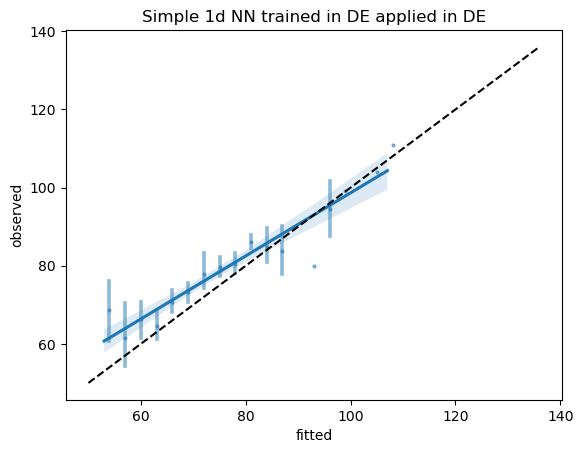

In [ ]:
temp_NDVI_series_SSA = torch.swapaxes(torch.stack((temp_series_SSA, photoperiod_series_SSA, NDVI_series_SSA)), 0, 1) #photoperiod_series_SSA, 
train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.1)
plot_from_saved('Simple_NN_KG_SAT_pp', model, val_dl_SSA, method = 'regression', bce=True, CNN=False, title = 'Simple 1d NN trained in DE applied in DE')#